<h2><center>회귀분석을 사용한 Ames 시 주택가격 예측 발표</center></h2>
<div style="text-align:right ; color:green"> 2018.03.15 </div>
<div style="text-align:right ; color:green"> 패스트캠퍼스 Subway 팀 </div>
<div style="text-align:right ; color:green"> (이준성, 박지선, 손대웅) </div>

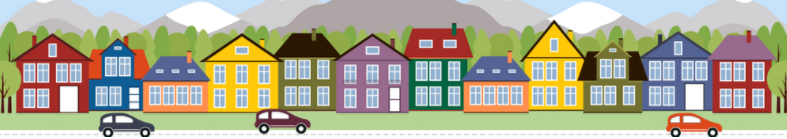

In [1]:
from IPython.display import Image
Image('./headImage.png')

### 순서
<ol>
  <li>데이터 전처리</li>
  <li>변수 선택</li>
  <li>모델 검증</li>
</ol>

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

# 경고창 보이지 않기
import warnings
warnings.filterwarnings('ignore')
# 그래프 설정
plt.rcParams["figure.figsize"] = (13,4)
%matplotlib inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# data 가져오기

df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df = pd.concat([df_train.drop('SalePrice', 1), df_test])

# EDA

## target data (종속변수 y)

In [4]:
y = df_train['SalePrice']
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### 시각화와 QQ plot

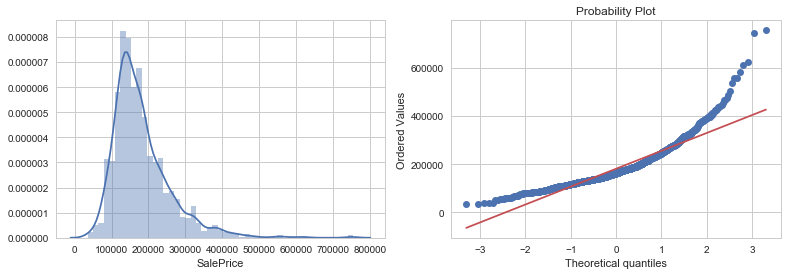

In [5]:
plt.rcParams["figure.figsize"] = (13,4)
plt.subplot(121)
sns.distplot(y)
plt.subplot(122)
sp.stats.probplot(y, plot=plt)
plt.show()

#### 한쪽으로 치우친 모습을 보임 -> log를 취해 정규분포의 모양에 가깝게 변환

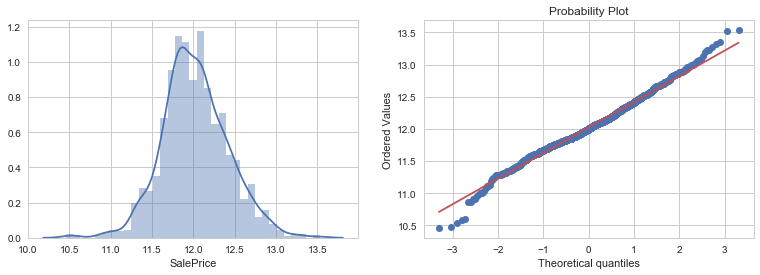

In [6]:
# log 변환
y2 = np.log(y)

# 시각화
plt.rcParams["figure.figsize"] = (13,4)

plt.subplot(121)
sns.distplot(y2)
## QQ plot
plt.subplot(122)
sp.stats.probplot(y2, plot=plt)
plt.show()

#### df_train의 SalePrice를 log 취해줌.

In [7]:
df_train['SalePrice'] = df_train['SalePrice'].apply(lambda x : np.log(x))

# feature data 확인

- info 함수
- https://goo.gl/19Qkf1 문서 참고

In [8]:
df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2433.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    23.344905    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    59.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    68.000000    9453.000000     6.000000   
75%    2189.500000    70.000000    80.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000   
mean      5.564577  1971.312778   1984.264474   102.201312   441.423235   
std       1.113131    30.291442     20.894344   179.334253   455.610826   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1953.500000   1965.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1993.000000     0.000000   368.500000   
75%       6.000000  2001.000000   2004.000000   164.000000   733.000000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

          ...        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count     ...       2918.000000  2919.000000  2919.000000    2919.000000   
mean      ...        472.874572    93.709832    47.486811      23.098321   
std       ...        215.394815   126.526589    67.575493      64.244246   
min       ...          0.000000     0.000000     0.000000       0.000000   
25%       ...        320.000000     0.000000     0.000000       0.000000   
50%       ...        480.000000     0.000000    26.000000       0.000000   
75%       ...        576.000000   168.000000    70.000000       0.000000   
max       ...       1488.000000  1424.000000   742.000000    1012.000000   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold  \
count  2919.000000  2919.000000  2919.000000   2919.000000  2919.000000   
mean      2.602261    16.062350     2.251799     50.825968     6.213087   
std      25.188169    56.184365    35.663946    567.402211     2.714762   
min       0.000000     0.000000     0.000000      0.000000     1.000000   
25%       0.000000     0.000000     0.000000      0.000000     4.000000   
50%       0.000000     0.000000     0.000000      0.000000     6.000000   
75%       0.000000     0.000000     0.000000      0.000000     8.000000   
max     508.000000   576.000000   800.000000  17000.000000    12.000000   

            YrSold  
count  2919.000000  
mean   2007.792737  
std       1.314964  
min    2006.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2010.000000  

[8 rows x 37 columns]

- 변수 info 확인

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

#### 실수값과 카테고리값
    - 카테고리 값 전처리 필요
#### missing data 처리 필요

## Null 값 처리

### missing data는 train과 test를 함께  본다 (캐글 제출을 고려)

- 카테고리 값 중에서 order가 있는 변수는 숫자로 바꿔서 회귀분석 진행
    - 그래프 상으로 봤을 때 등급이 올라가면 대체로 SalePrice가 올라감을 확인
- null 값은 해당 항목에 대한 '시설'이 없는 것임으로 점수를 0으로 매겨줌

In [10]:
# null 있는 column 체크
def nan_check(df_raw):
    null_check = df_raw.isnull().sum()
    null_count = pd.DataFrame({'column' : null_check.index, 'NaN' : null_check.values})
    # None 값이 있는 column만 가져옴.
    null_count = null_count.query('NaN > 0')
    return(null_count)

# null 없는 column 체크
def nan_check2(df_raw):
    null_check = df_raw.isnull().sum()
    null_count = pd.DataFrame({'column' : null_check.index, 'NaN' : null_check.values})
    # None 값이 없는 column만 가져옴.
    null_count = null_count.query('NaN == 0')
    return(null_count)

train, test 데이터에 대한 null 값 체크

In [11]:
nan_check(df)

NaN        column
2      4      MSZoning
3    486   LotFrontage
6   2721         Alley
9      2     Utilities
23     1   Exterior1st
24     1   Exterior2nd
25    24    MasVnrType
26    23    MasVnrArea
30    81      BsmtQual
31    82      BsmtCond
32    82  BsmtExposure
33    79  BsmtFinType1
34     1    BsmtFinSF1
35    80  BsmtFinType2
36     1    BsmtFinSF2
37     1     BsmtUnfSF
38     1   TotalBsmtSF
42     1    Electrical
47     2  BsmtFullBath
48     2  BsmtHalfBath
53     1   KitchenQual
55     2    Functional
57  1420   FireplaceQu
58   157    GarageType
59   159   GarageYrBlt
60   159  GarageFinish
61     1    GarageCars
62     1    GarageArea
63   159    GarageQual
64   159    GarageCond
72  2909        PoolQC
73  2348         Fence
74  2814   MiscFeature
78     1      SaleType

### 순서가 있는 카테고리 데이터에 숫자 부여

In [12]:
tonum = {"ExterQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "ExterCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "HeatingQC": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "KitchenQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "FireplaceQu": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "GarageQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "GarageCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "PoolQC": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtFinType1" : {'GLQ' : 6, 'ALQ' : 5, 'BLQ': 4,'Rec' : 3,'LwQ' : 2, 'Unf' : 1, np.nan : 0},
         "BsmtFinType2" : {'GLQ' : 6, 'ALQ' : 5, 'BLQ': 4,'Rec' : 3,'LwQ' : 2, 'Unf' : 1, np.nan : 0},
         "BsmtExposure" : {'Gd' : 4, 'Av': 3,'Mn' : 2,'No' : 1, np.nan : 0},
        }

df= df.replace(tonum)

- nan 값이 '시설 없음'인 변수들에 대해서 'N' 이라는 클래스를 부여해 줌 : 카테고리 값
- nan 값이 '시설 없음'인 변수들에 대해서 0으로 대체 : 실수 값

In [13]:
fill_na_ls = ['GarageType', 'MiscFeature', 'Fence', 'GarageFinish', 'Alley', 'MasVnrType']

for name in fill_na_ls:
    df[name] = df[name].fillna('N')

fill_zero_ls = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'MasVnrArea']

for name in fill_zero_ls:
    df[name] = df[name].fillna(0)
    
fill_mode_ls = ['Electrical', 'Utilities', 'Functional', 'MSZoning', 'SaleType', 'LotFrontage', 'Exterior1st', 'Exterior2nd']
for name in fill_mode_ls:
    df[name] = df[name].fillna(df[name].mode()[0])

#### 비슷한 항목인 집의 넓이를 TotSF라는 항목으로 합해줌.

In [14]:
df['TotSF'] = df['1stFlrSF'] + df['TotalBsmtSF'] + df['2ndFlrSF']

#### null 값 없음 체크

In [15]:
nan_check(df)

Empty DataFrame
Columns: [NaN, column]
Index: []

### test DataFrame 와 분리
- df : train data
- df_test : test data

In [16]:
df_test = df.iloc[1460:]
df = df.iloc[:1460]
df['SalePrice'] = df_train['SalePrice']

### 변수 살펴보기

In [17]:
# 카테고리 변수
cat_ls = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'GarageCars', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'GarageYrBlt', 'BsmtFullBath', 'BedroomAbvGr', 'MoSold', 'BsmtHalfBath', 'YrSold', 'KitchenAbvGr']
df_cat = df[cat_ls]
df_cat['SalePrice'] = df['SalePrice']

# 실수 변수
num_ls = list(set(df.columns) - set(cat_ls))
df_num = df[num_ls]
df_num['SalePrice'] = df['SalePrice']

# 실수가 아닌 카테고리 변수
str_cat_ls = ['Alley', 'PavedDrive', 'Functional', 'MSZoning', 'LandSlope', 'GarageType', 'Exterior1st', 'Neighborhood', 'SaleType', 'LandContour', 'Electrical', 'MasVnrType', 'LotShape', 'Fence', 'HouseStyle', 'Street', 'GarageFinish', 'BldgType', 'CentralAir', 'Condition1', 'Foundation', 'RoofStyle', 'MiscFeature', 'LotConfig', 'RoofMatl', 'Condition2', 'Heating', 'Utilities', 'Exterior2nd', 'SaleCondition']

## numerical data

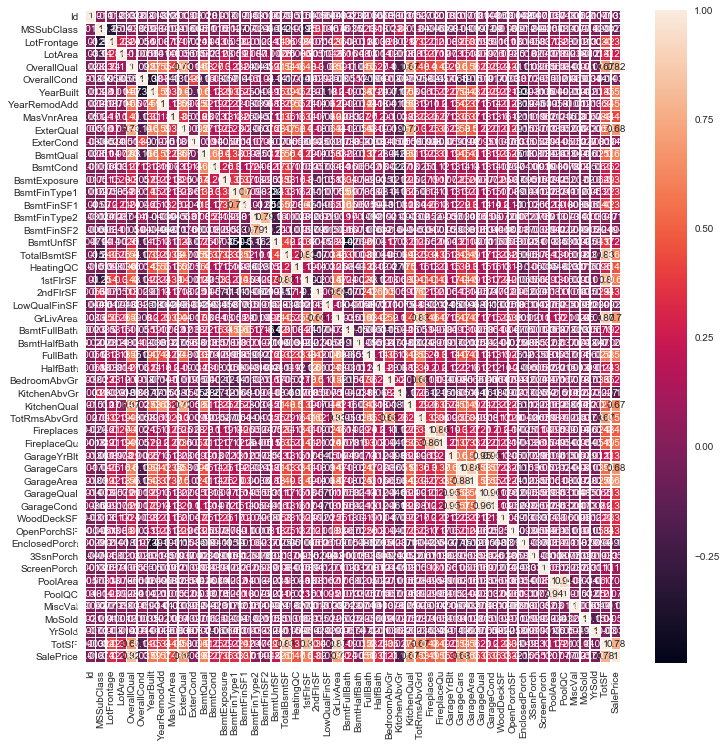

In [18]:
heat= df.corr()
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(heat.iloc[:, :], annot=True, linewidths=.5, ax=ax)

In [19]:
df_heat= pd.DataFrame(heat['SalePrice'].sort_values(ascending=False))
df_heat.head(15)

SalePrice
SalePrice      1.000000
OverallQual    0.817184
TotSF          0.777296
GrLivArea      0.700927
GarageCars     0.680625
ExterQual      0.678840
KitchenQual    0.667893
GarageArea     0.650888
BsmtQual       0.615804
TotalBsmtSF    0.612134
1stFlrSF       0.596981
FullBath       0.594771
YearBuilt      0.586570
YearRemodAdd   0.565608
FireplaceQu    0.546362

### 상관계수가 높은 데이터를 plot과 함께 살펴봄

<  SalePrice  >
1.0


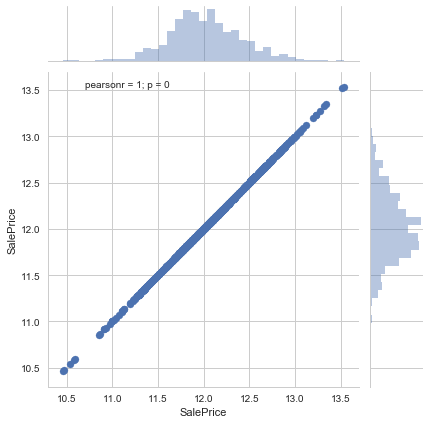

<  OverallQual  >
0.8171844179216822


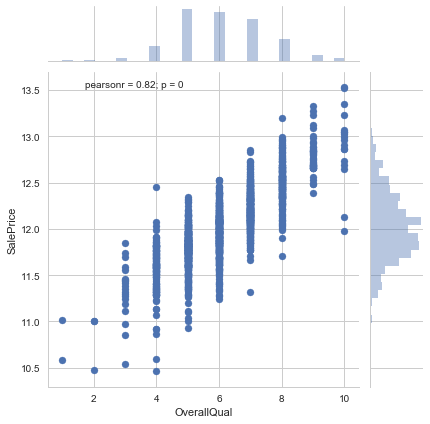

<  TotSF  >
0.777296214853449


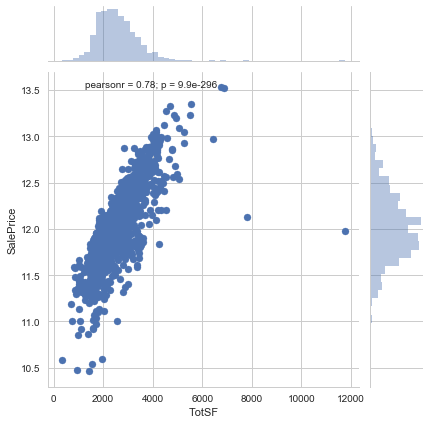

<  GrLivArea  >
0.7009266525441293


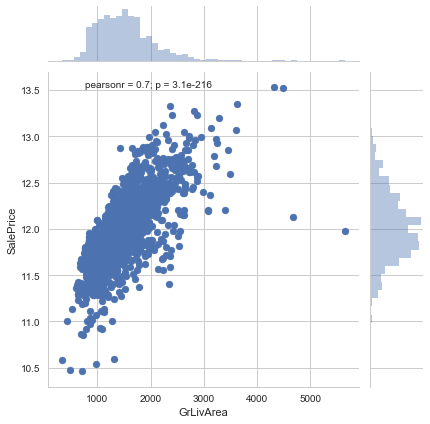

<  GarageCars  >
0.6806248074360439


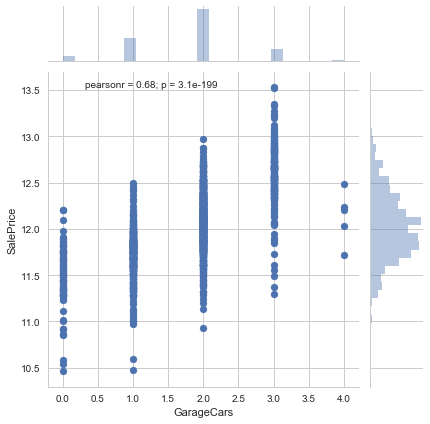

<  ExterQual  >
0.6788398348643062


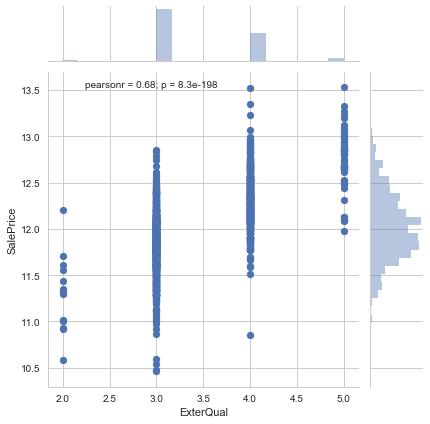

<  KitchenQual  >
0.6678930256021587


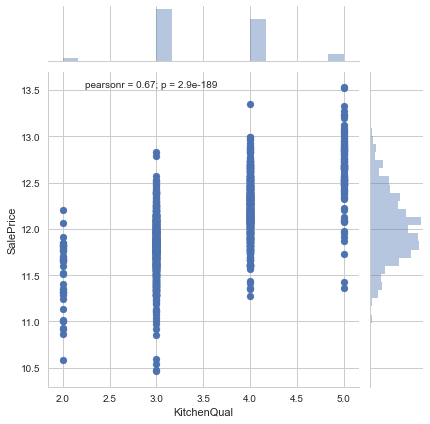

<  GarageArea  >
0.6508875559020062


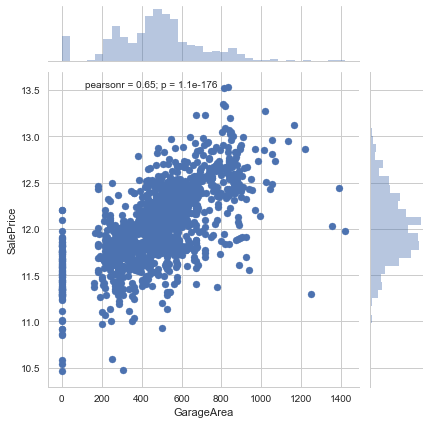

<  BsmtQual  >
0.615803610631306


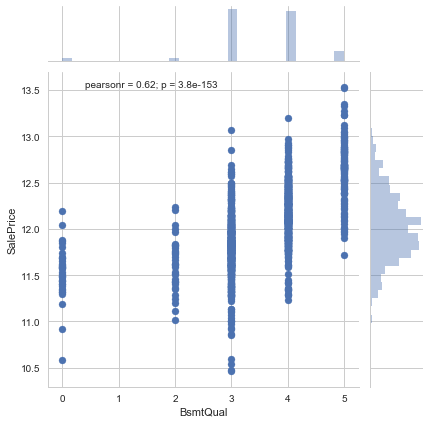

<  TotalBsmtSF  >
0.6121339753697865


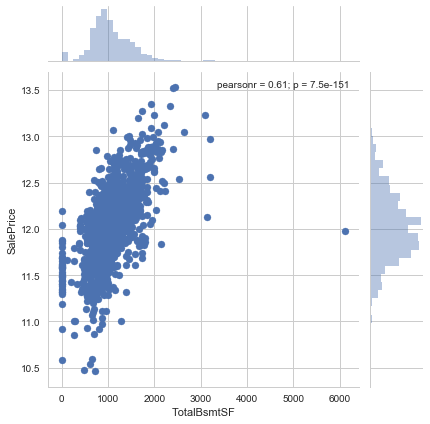

<  1stFlrSF  >
0.596981045034374


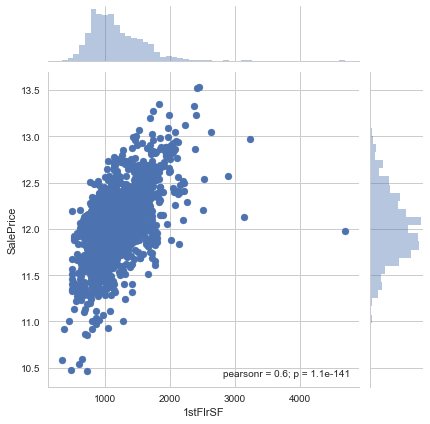

<  FullBath  >
0.5947705420075314


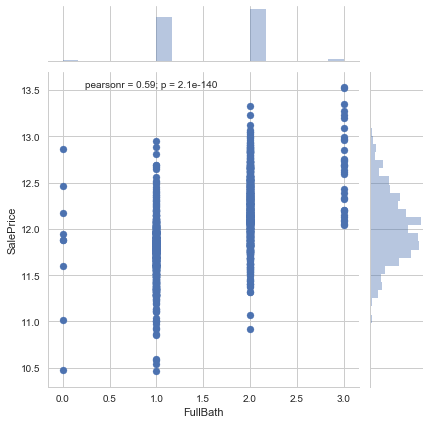

<  YearBuilt  >
0.5865702403842262


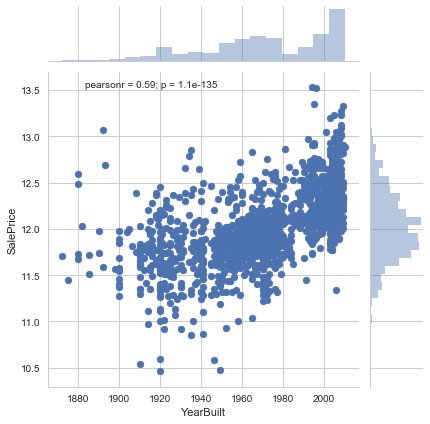

<  YearRemodAdd  >
0.5656078325911801


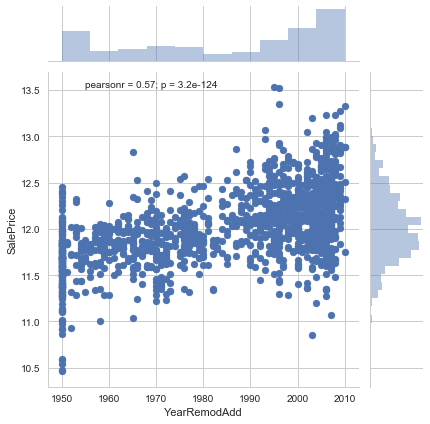

<  FireplaceQu  >
0.5463619772573702


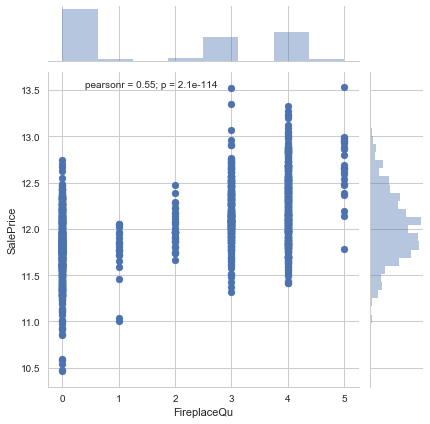

<  TotRmsAbvGrd  >
0.5344222037231195


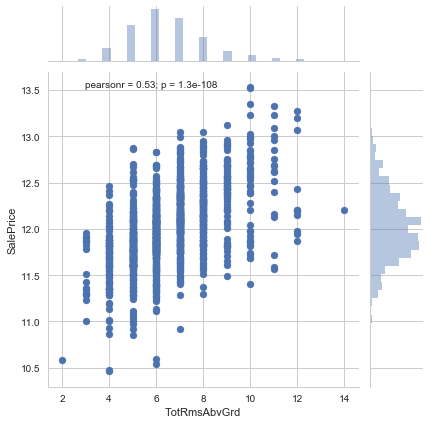

<  Fireplaces  >
0.48944942759848153


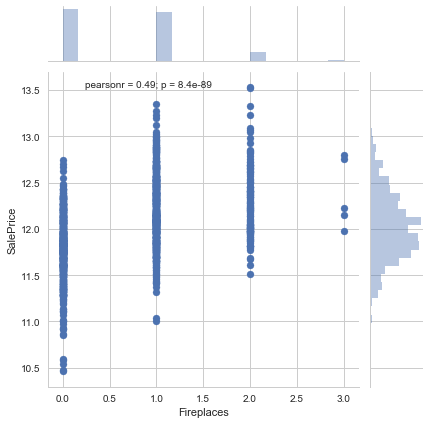

<  HeatingQC  >
0.47376166271420506


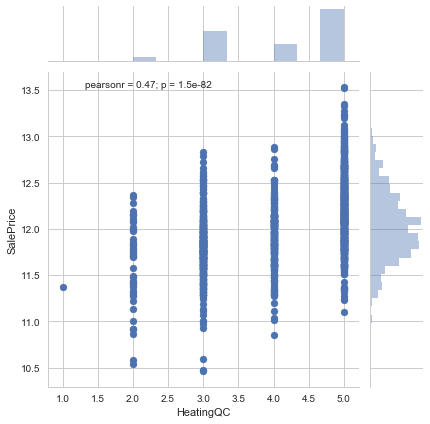

<  MasVnrArea  >
0.42677513183636906


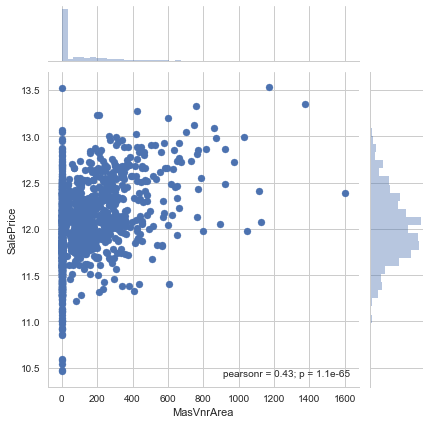

<  BsmtFinSF1  >
0.3720230735670904


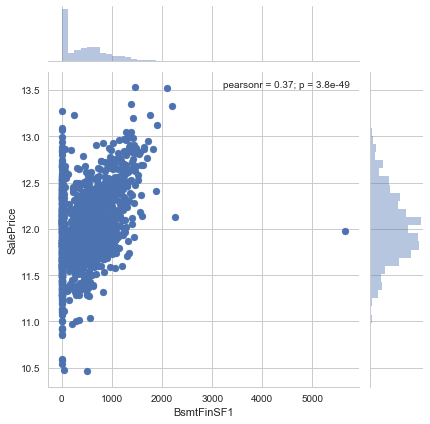

<  GarageQual  >
0.3632588687651534


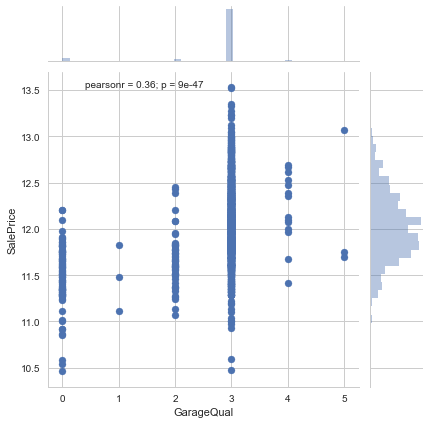

<  BsmtExposure  >
0.35742109703492314


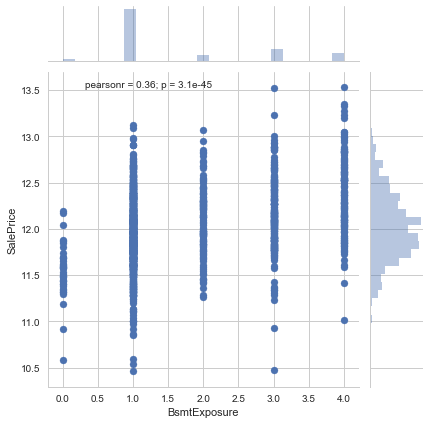

<  GarageCond  >
0.35676696750459974


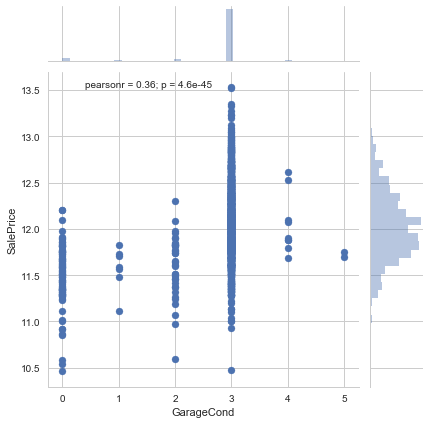

<  GarageYrBlt  >
0.3490136169886158


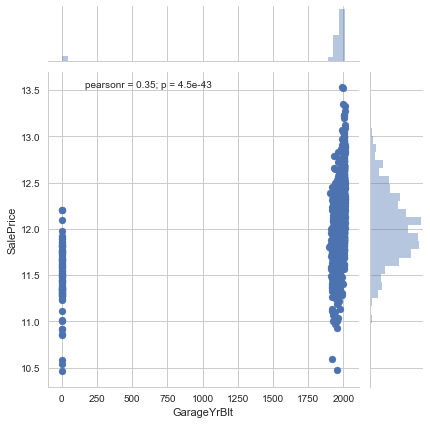

<  BsmtFinType1  >
0.3348025751708096


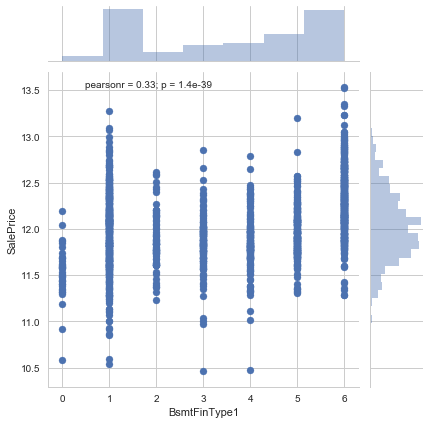

<  WoodDeckSF  >
0.3341350739575136


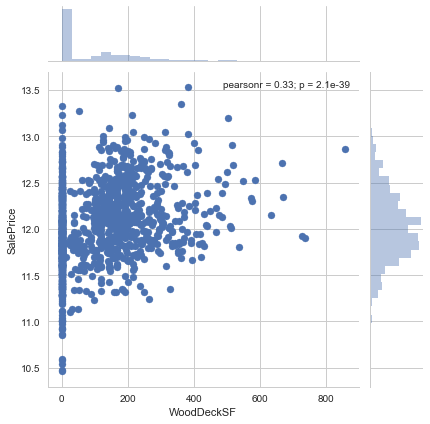

<  LotFrontage  >
0.3235342879004603


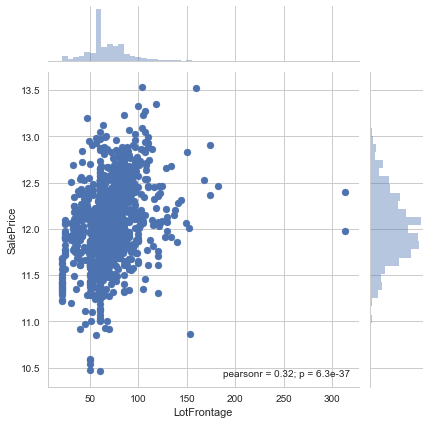

<  OpenPorchSF  >
0.3210529720197666


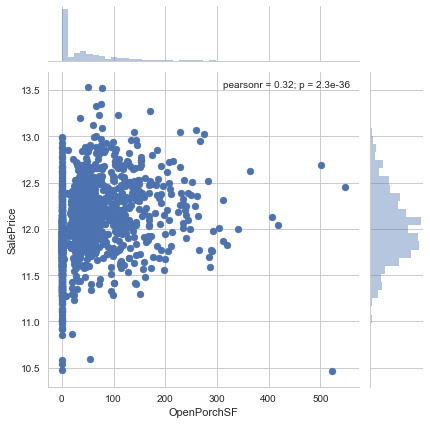

<  2ndFlrSF  >
0.3192999843472038


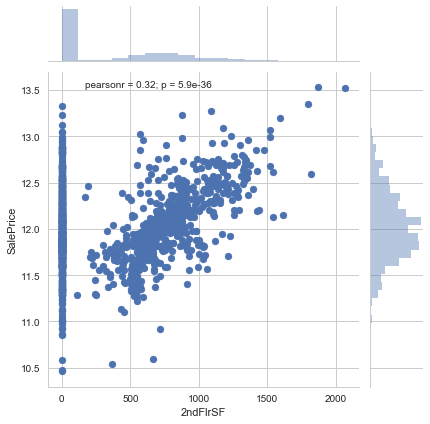

<  HalfBath  >
0.3139822499151441


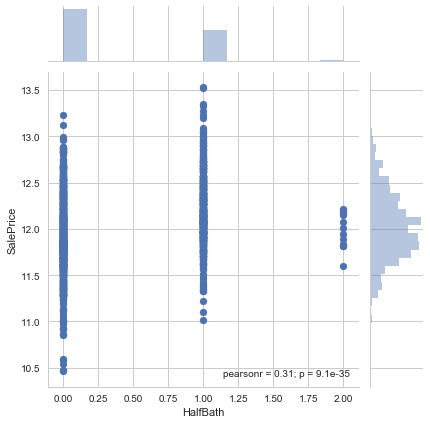

<  BsmtCond  >
0.274543033311263


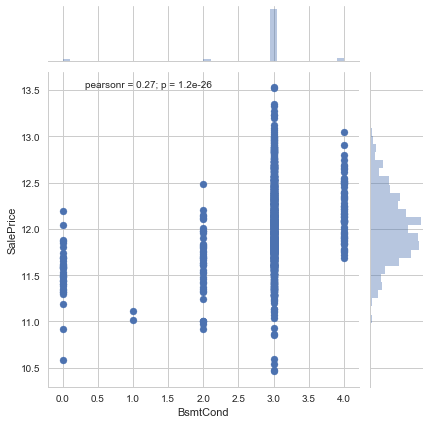

<  LotArea  >
0.25731989235273833


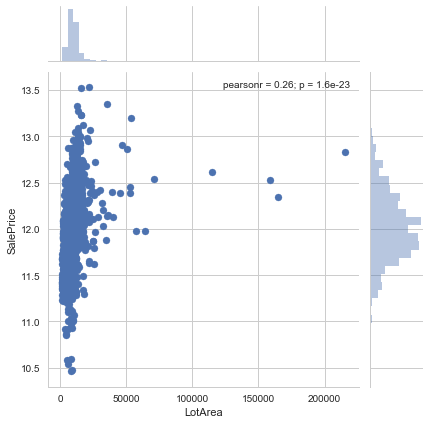

<  BsmtFullBath  >
0.2362241088243532


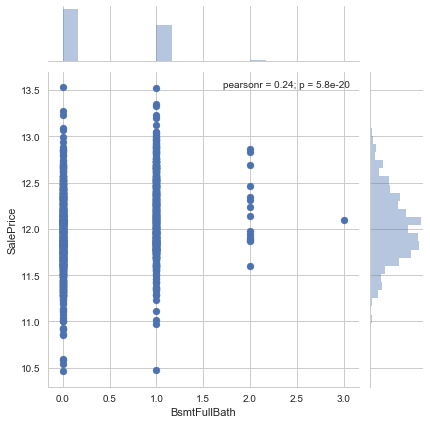

<  BsmtUnfSF  >
0.22198505352520953


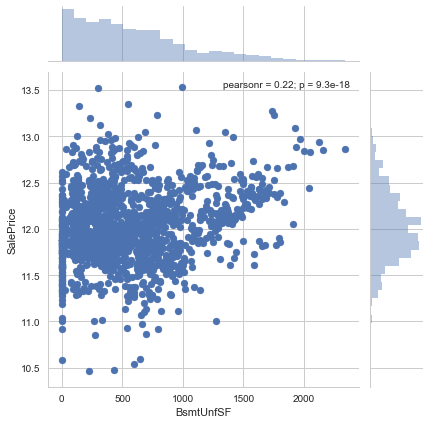

<  BedroomAbvGr  >
0.20904368212692215


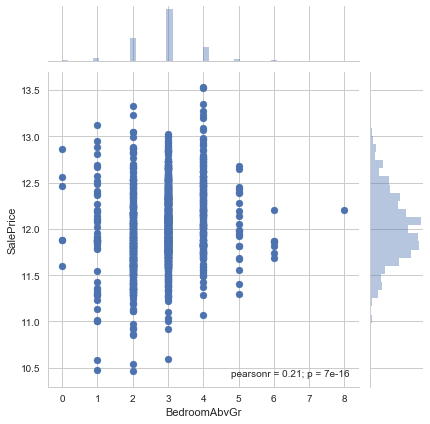

<  ScreenPorch  >
0.12120760489686298


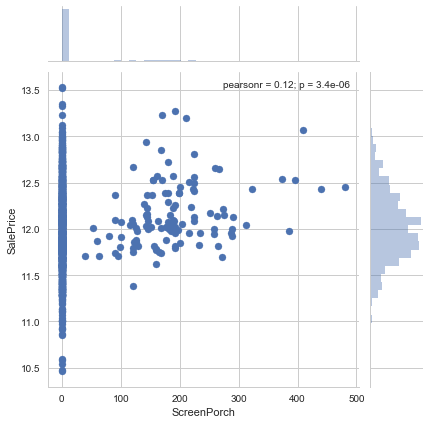

<  PoolQC  >
0.0772914921383458


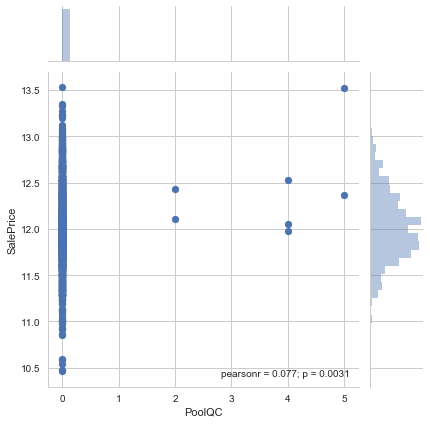

<  PoolArea  >
0.06979780600969131


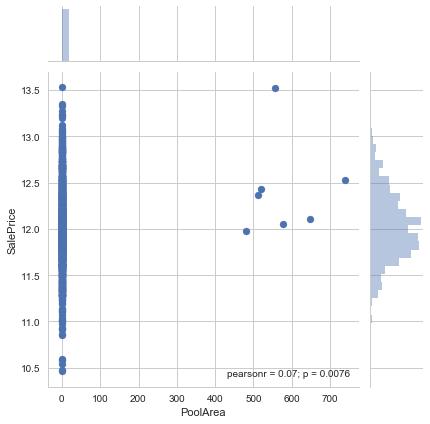

<  MoSold  >
0.05732948459791035


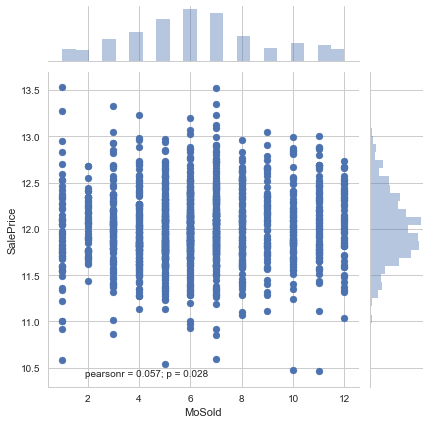

<  3SsnPorch  >
0.05490022646761992


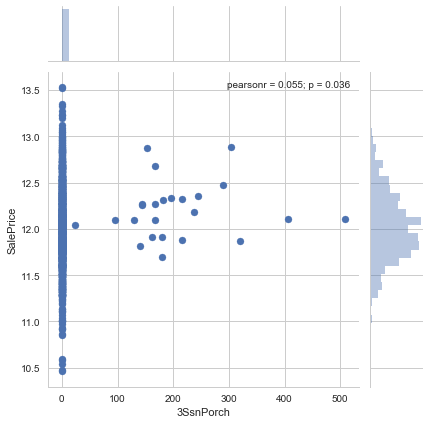

<  ExterCond  >
0.04931363215047721


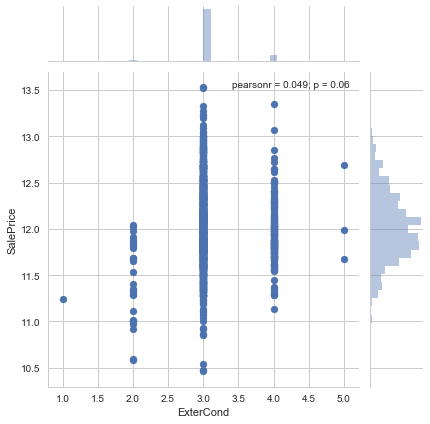

<  BsmtFinType2  >
0.014034128493952476


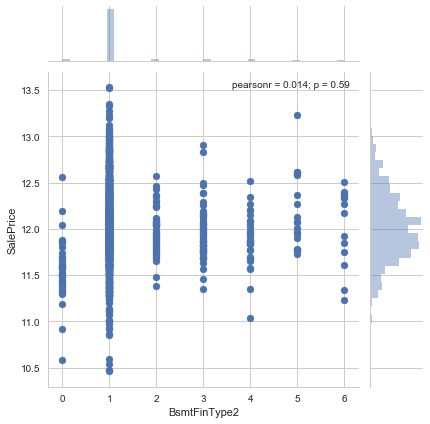

<  BsmtFinSF2  >
0.0048324105320466755


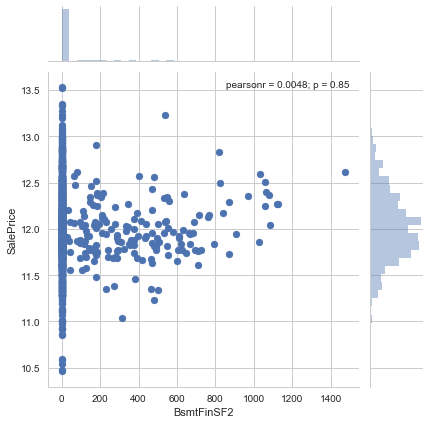

<  BsmtHalfBath  >
-0.005149094053239845


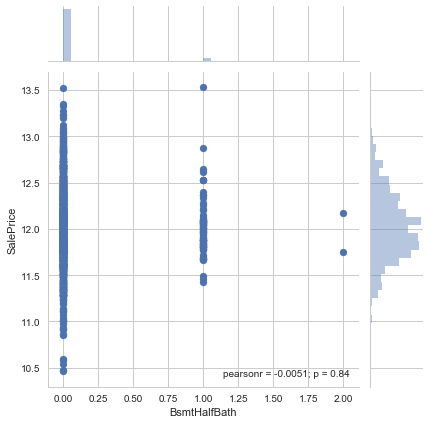

<  Id  >
-0.017942382438871578


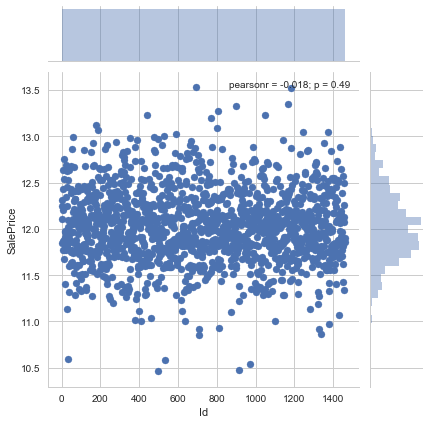

<  MiscVal  >
-0.020020820155023815


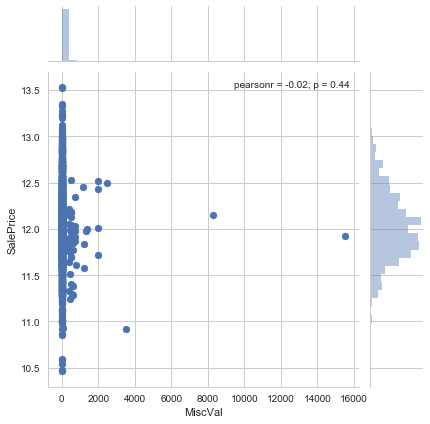

<  OverallCond  >
-0.03686798773028383


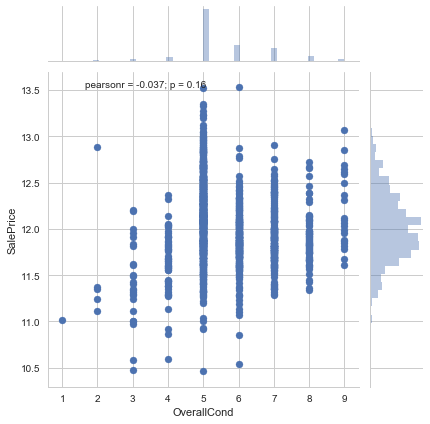

<  YrSold  >
-0.03726296946313519


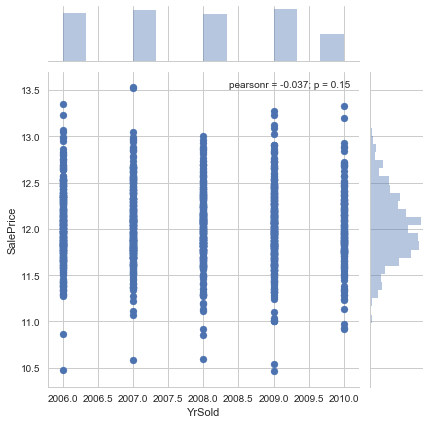

<  LowQualFinSF  >
-0.03796280313742792


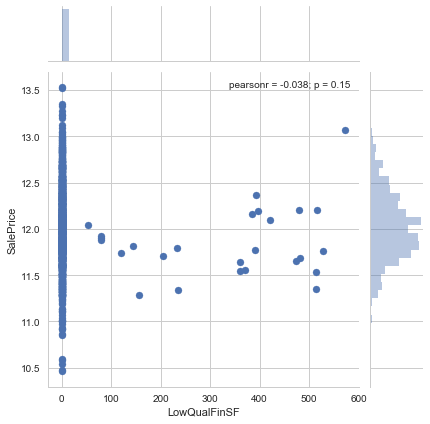

<  MSSubClass  >
-0.07395901733239706


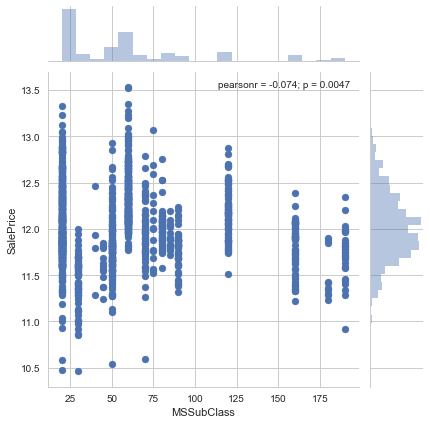

<  KitchenAbvGr  >
-0.14754808847658205


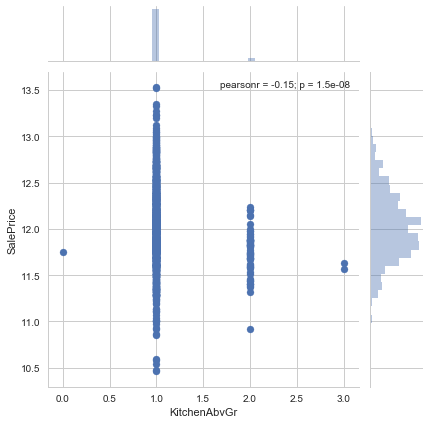

<  EnclosedPorch  >
-0.1490502814276759


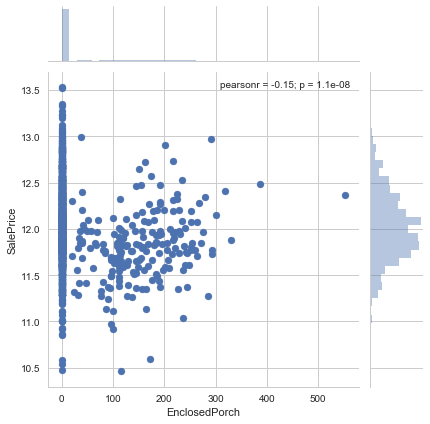

In [20]:
corr = heat['SalePrice'].sort_values(ascending=False)

for col_name in corr.index:
    print("< ",col_name," >")
    print(corr[col_name])
    sns.jointplot(x=col_name, y="SalePrice", data=df)
    plt.show()

## numeric data 선택

OverallQual, TotSF, GrLivArea, GarageCars, ExterQual, KitchenQual, GarageArea, BsmtQual, YearBuilt, YearRemodAdd, OverallCond

## categorical data

- one-way ANOVA를 통해 p-value, $R^2$, $R^2_{adj}$ 구함  (`scipy.stats`사용)

In [21]:
# one-way ANOVA 시행 예시
import scipy.stats as scipystats
scipystats.f_oneway(df.loc[df["KitchenAbvGr"] == 0].SalePrice,
                    df.loc[df["KitchenAbvGr"] == 3].SalePrice,
                    df.loc[df["KitchenAbvGr"] == 1].SalePrice,
                    df.loc[df["KitchenAbvGr"] == 2].SalePrice)

F_onewayResult(statistic=11.534894703481985, pvalue=1.7875405872957032e-07)

In [22]:
# 결과는 f_p_value.csv에 따로 저장
f_p_value = pd.read_csv('./f_p_value.csv', index_col=0)

In [23]:
anova_test = pd.DataFrame(columns=['col_name', 'f-test', 'rs', 'rs_a'])
for x1 in str_cat_ls:
    model = sm.OLS.from_formula("SalePrice ~ C({}) + 0".format(x1), data=df)
    
    result = model.fit()
    rs = result.rsquared
    rs_a = result.rsquared_adj
    f_test = f_p_value['pvalue'][x1]
    
    anova_test = anova_test.append({'col_name': x1, 'f-test':f_test, 'rs':rs, 'rs_a':rs_a}, ignore_index=True)
    
anova_test.sort_values('f-test', ascending=True)

col_name         f-test        rs      rs_a
7    Neighborhood  1.497729e-224  0.570808  0.563630
16   GarageFinish   1.199117e-93  0.381034  0.379758
20     Foundation   5.791895e-91  0.303651  0.301257
5      GarageType   1.247154e-66  0.334639  0.331892
11     MasVnrType   4.793331e-65  0.194503  0.192289
29  SaleCondition   7.988268e-44  0.129020  0.126025
6     Exterior1st   2.586089e-43  0.181531  0.173601
28    Exterior2nd   4.842186e-43  0.171463  0.162856
8        SaleType   5.039767e-42  0.120115  0.115264
3        MSZoning   8.817634e-35  0.175839  0.173573
14     HouseStyle   3.376777e-25  0.102097  0.097768
12       LotShape   6.447524e-25  0.087826  0.085946
10     Electrical   1.663249e-18  0.096518  0.094034
1      PavedDrive   1.803569e-18  0.093227  0.091982
21      RoofStyle   3.653523e-17  0.043098  0.039807
17       BldgType   2.056736e-10  0.040140  0.037502
9     LandContour   2.742217e-08  0.025632  0.023624
0           Alley   4.899826e-08  0.027637  0.026302
24       RoofMatl   7.231445e-08  0.017900  0.013165
19     Condition1   8.904549e-08  0.042434  0.037154
23      LotConfig   3.163167e-06  0.023339  0.020654
2      Functional   4.841697e-04  0.023789  0.019758
26        Heating   7.534721e-04  0.032946  0.029620
13          Fence   2.312646e-03  0.042392  0.039760
25     Condition2   4.342566e-02  0.012039  0.007276
22    MiscFeature   1.047276e-01  0.009857  0.007135
4       LandSlope   1.413964e-01  0.001484  0.000114
15         Street            NaN  0.003291  0.002608
18     CentralAir            NaN  0.123623  0.123022
27      Utilities            NaN  0.000160 -0.000526

### 카테고리 데이터 시각화

In [24]:
def show_viobox(df,col_name):
    print(col_name)
        
    # 각 항목에 대한 빈도 출력 / df2 dataframe 따로 생성
    df2 = pd.DataFrame(df[col_name])
    counts = df2.groupby([col_name]).size().reset_index(name='Counts')
    print(counts)
        
    plt.subplot(121)
    sns.violinplot(x=col_name, y='SalePrice', data=df)
    plt.subplot(122)
    sns.boxplot(x=col_name, y='SalePrice', data=df)
    plt.show()

MSSubClass
    MSSubClass  Counts
0           20     536
1           30      69
2           40       4
3           45      12
4           50     144
5           60     299
6           70      60
7           75      16
8           80      58
9           85      20
10          90      52
11         120      87
12         160      63
13         180      10
14         190      30


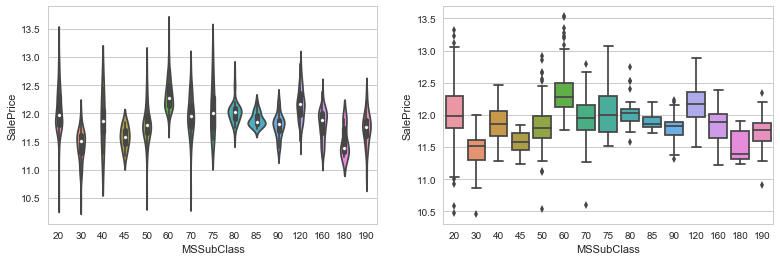

MSZoning
  MSZoning  Counts
0  C (all)      10
1       FV      65
2       RH      16
3       RL    1151
4       RM     218


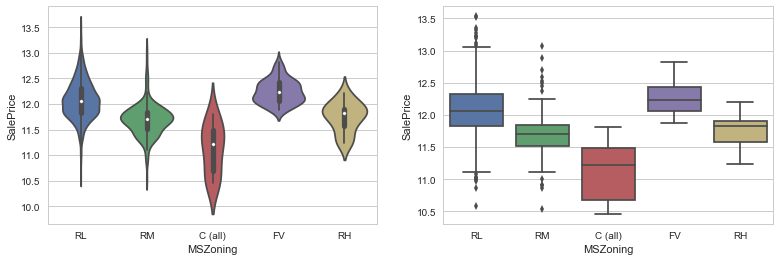

Street
  Street  Counts
0   Grvl       6
1   Pave    1454


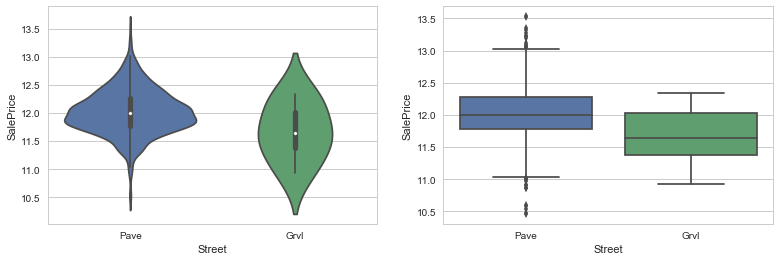

Alley
  Alley  Counts
0  Grvl      50
1     N    1369
2  Pave      41


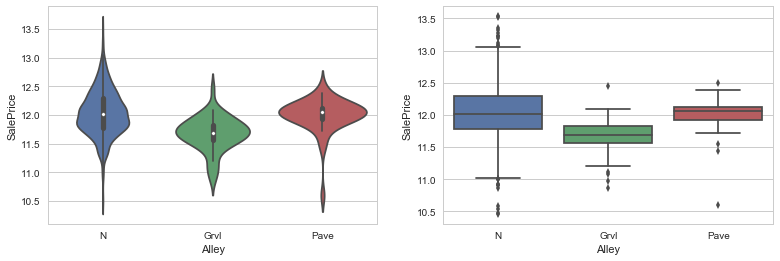

LotShape
  LotShape  Counts
0      IR1     484
1      IR2      41
2      IR3      10
3      Reg     925


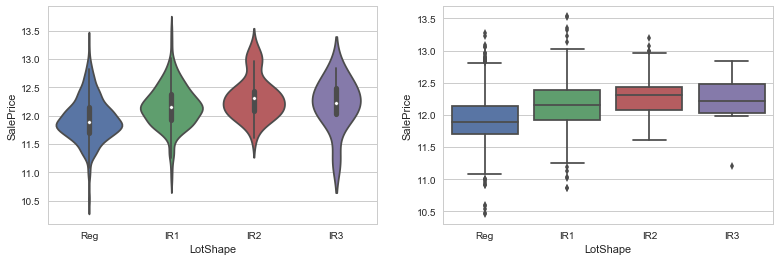

LandContour
  LandContour  Counts
0         Bnk      63
1         HLS      50
2         Low      36
3         Lvl    1311


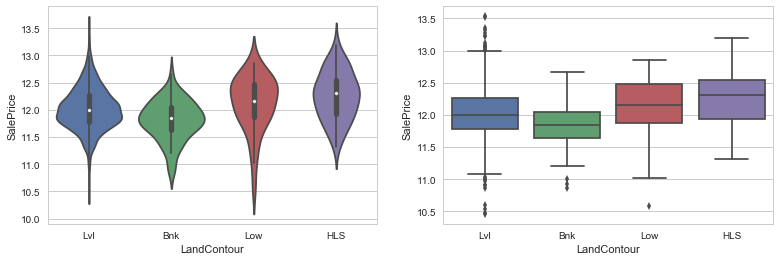

Utilities
  Utilities  Counts
0    AllPub    1459
1    NoSeWa       1


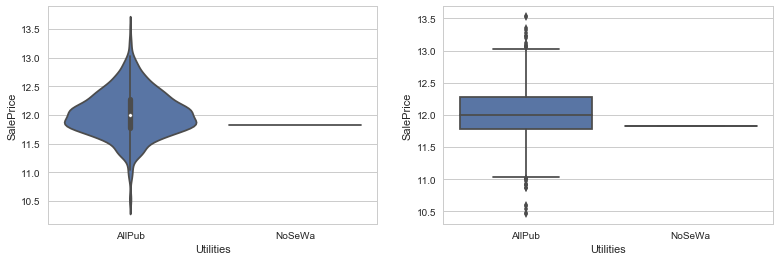

LotConfig
  LotConfig  Counts
0    Corner     263
1   CulDSac      94
2       FR2      47
3       FR3       4
4    Inside    1052


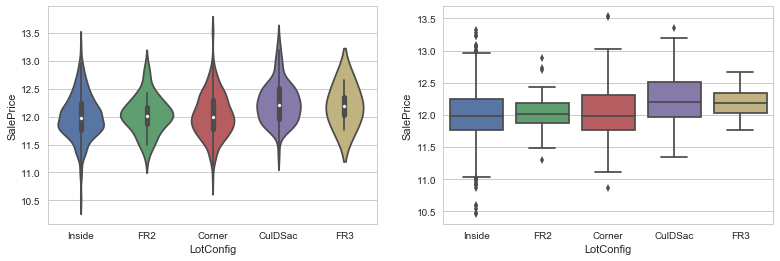

LandSlope
  LandSlope  Counts
0       Gtl    1382
1       Mod      65
2       Sev      13


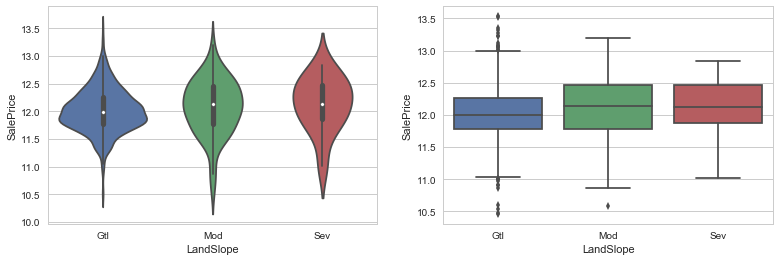

Neighborhood
   Neighborhood  Counts
0       Blmngtn      17
1       Blueste       2
2        BrDale      16
3       BrkSide      58
4       ClearCr      28
5       CollgCr     150
6       Crawfor      51
7       Edwards     100
8       Gilbert      79
9        IDOTRR      37
10      MeadowV      17
11      Mitchel      49
12        NAmes     225
13      NPkVill       9
14       NWAmes      73
15      NoRidge      41
16      NridgHt      77
17      OldTown     113
18        SWISU      25
19       Sawyer      74
20      SawyerW      59
21      Somerst      86
22      StoneBr      25
23       Timber      38
24      Veenker      11


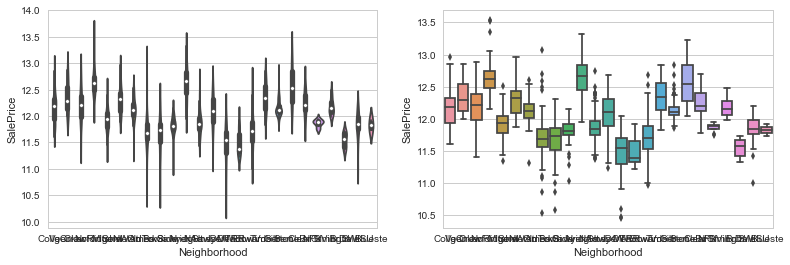

Condition1
  Condition1  Counts
0     Artery      48
1      Feedr      81
2       Norm    1260
3       PosA       8
4       PosN      19
5       RRAe      11
6       RRAn      26
7       RRNe       2
8       RRNn       5


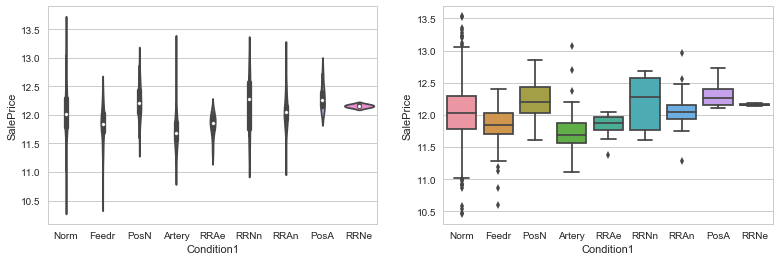

Condition2
  Condition2  Counts
0     Artery       2
1      Feedr       6
2       Norm    1445
3       PosA       1
4       PosN       2
5       RRAe       1
6       RRAn       1
7       RRNn       2


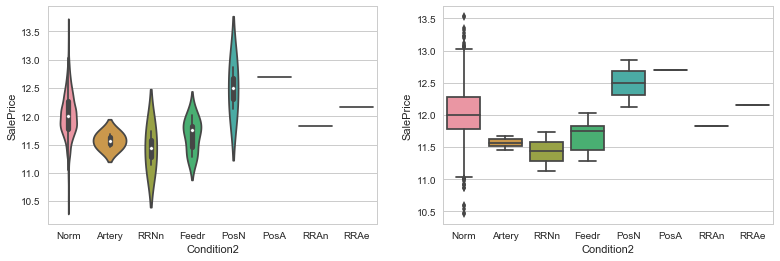

BldgType
  BldgType  Counts
0     1Fam    1220
1   2fmCon      31
2   Duplex      52
3    Twnhs      43
4   TwnhsE     114


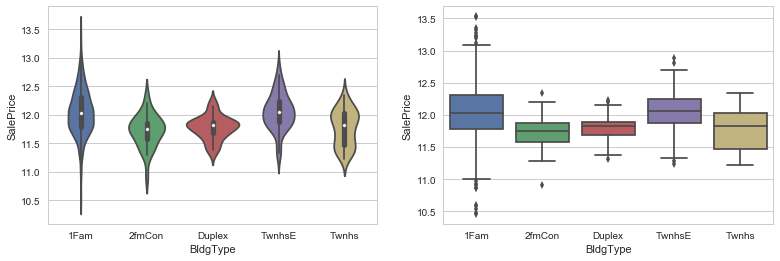

HouseStyle
  HouseStyle  Counts
0     1.5Fin     154
1     1.5Unf      14
2     1Story     726
3     2.5Fin       8
4     2.5Unf      11
5     2Story     445
6     SFoyer      37
7       SLvl      65


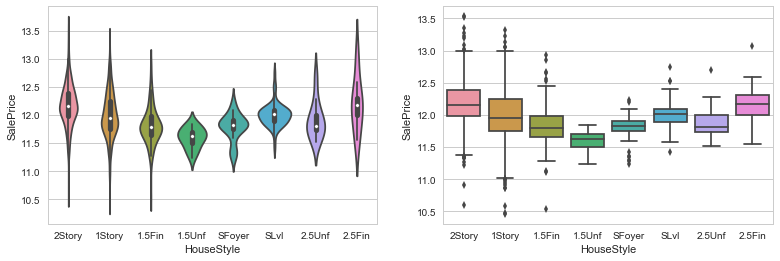

OverallQual
   OverallQual  Counts
0            1       2
1            2       3
2            3      20
3            4     116
4            5     397
5            6     374
6            7     319
7            8     168
8            9      43
9           10      18


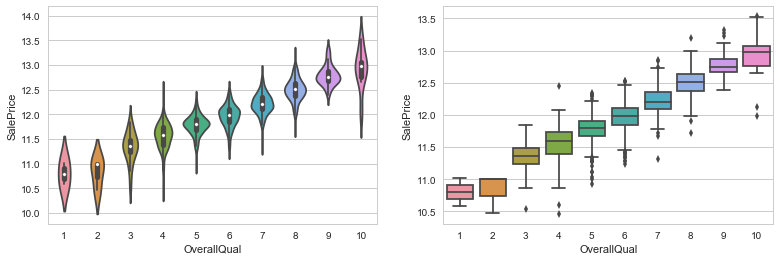

OverallCond
   OverallCond  Counts
0            1       1
1            2       5
2            3      25
3            4      57
4            5     821
5            6     252
6            7     205
7            8      72
8            9      22


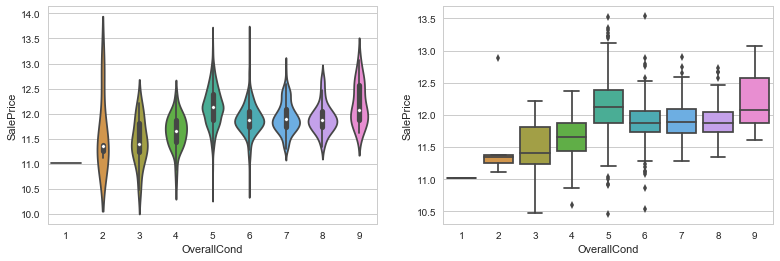

RoofStyle
  RoofStyle  Counts
0      Flat      13
1     Gable    1141
2   Gambrel      11
3       Hip     286
4   Mansard       7
5      Shed       2


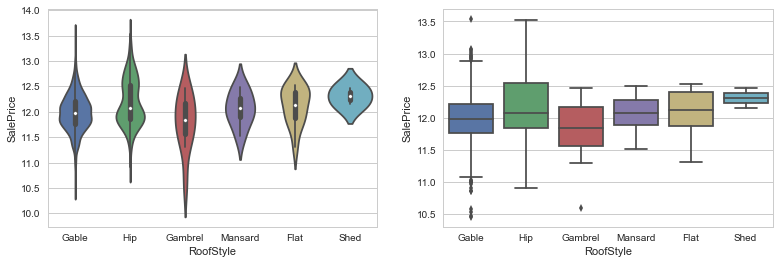

RoofMatl
  RoofMatl  Counts
0  ClyTile       1
1  CompShg    1434
2  Membran       1
3    Metal       1
4     Roll       1
5  Tar&Grv      11
6  WdShake       5
7  WdShngl       6


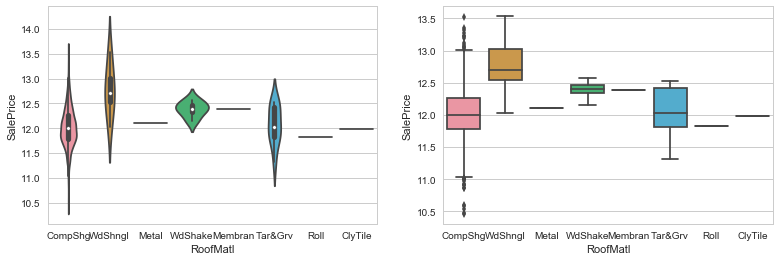

Exterior1st
   Exterior1st  Counts
0      AsbShng      20
1      AsphShn       1
2      BrkComm       2
3      BrkFace      50
4       CBlock       1
5      CemntBd      61
6      HdBoard     222
7      ImStucc       1
8      MetalSd     220
9      Plywood     108
10       Stone       2
11      Stucco      25
12     VinylSd     515
13     Wd Sdng     206
14     WdShing      26


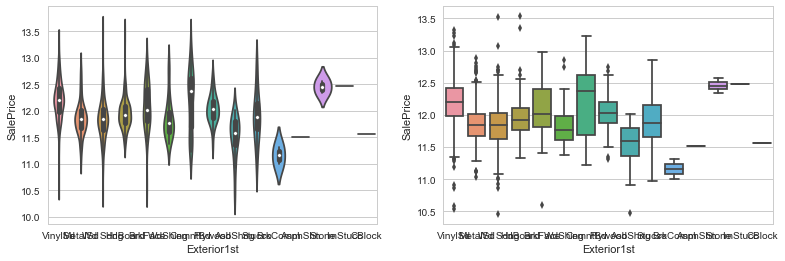

Exterior2nd
   Exterior2nd  Counts
0      AsbShng      20
1      AsphShn       3
2      Brk Cmn       7
3      BrkFace      25
4       CBlock       1
5      CmentBd      60
6      HdBoard     207
7      ImStucc      10
8      MetalSd     214
9        Other       1
10     Plywood     142
11       Stone       5
12      Stucco      26
13     VinylSd     504
14     Wd Sdng     197
15     Wd Shng      38


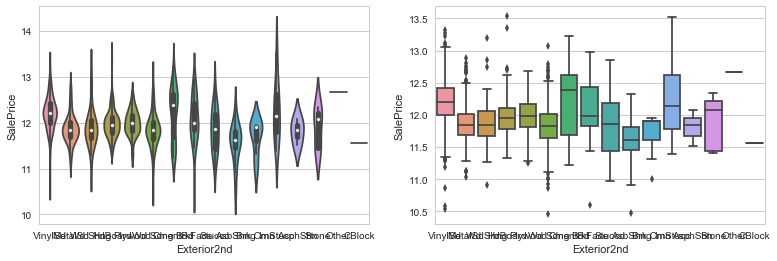

MasVnrType
  MasVnrType  Counts
0     BrkCmn      15
1    BrkFace     445
2          N       8
3       None     864
4      Stone     128


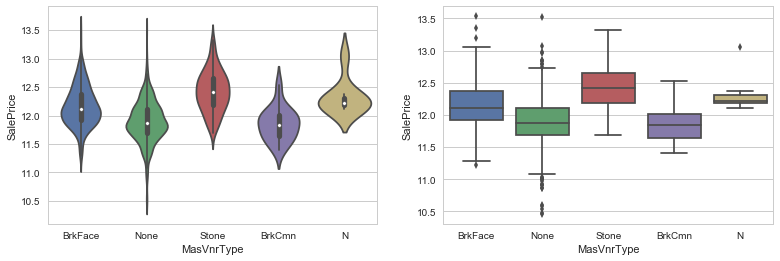

ExterQual
   ExterQual  Counts
0          2      14
1          3     906
2          4     488
3          5      52


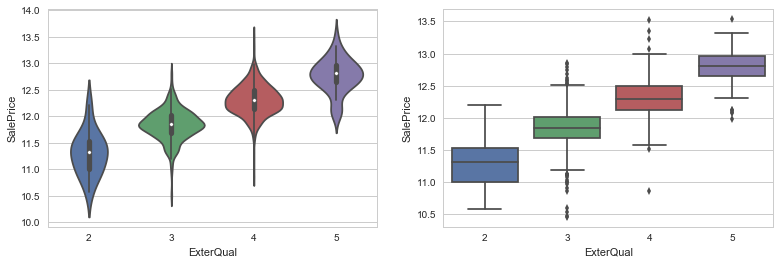

ExterCond
   ExterCond  Counts
0          1       1
1          2      28
2          3    1282
3          4     146
4          5       3


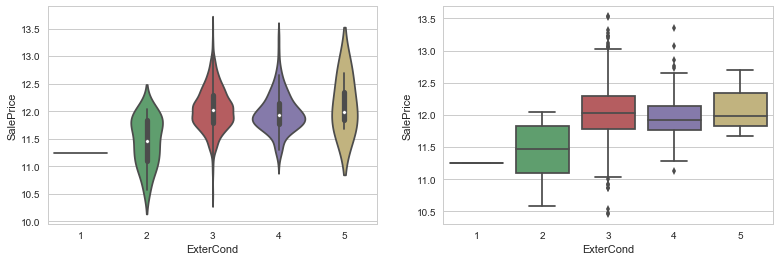

Foundation
  Foundation  Counts
0     BrkTil     146
1     CBlock     634
2      PConc     647
3       Slab      24
4      Stone       6
5       Wood       3


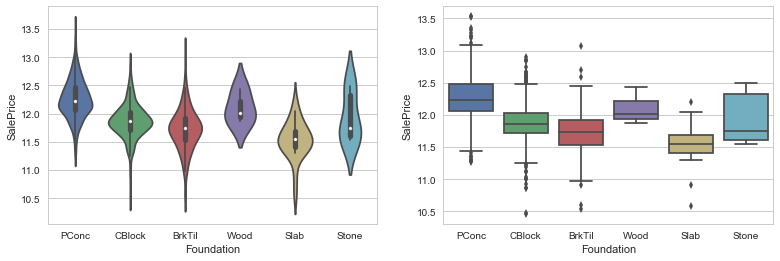

BsmtQual
   BsmtQual  Counts
0         0      37
1         2      35
2         3     649
3         4     618
4         5     121


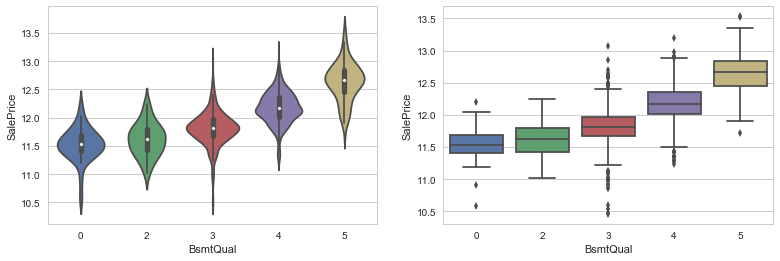

BsmtCond
   BsmtCond  Counts
0         0      37
1         1       2
2         2      45
3         3    1311
4         4      65


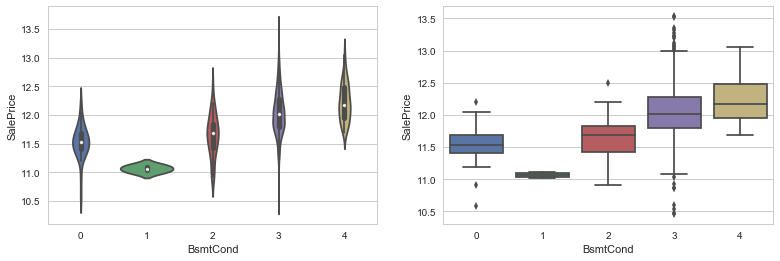

BsmtExposure
   BsmtExposure  Counts
0             0      38
1             1     953
2             2     114
3             3     221
4             4     134


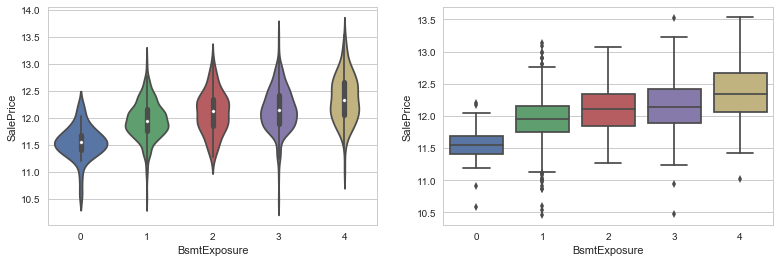

BsmtFinType1
   BsmtFinType1  Counts
0             0      37
1             1     430
2             2      74
3             3     133
4             4     148
5             5     220
6             6     418


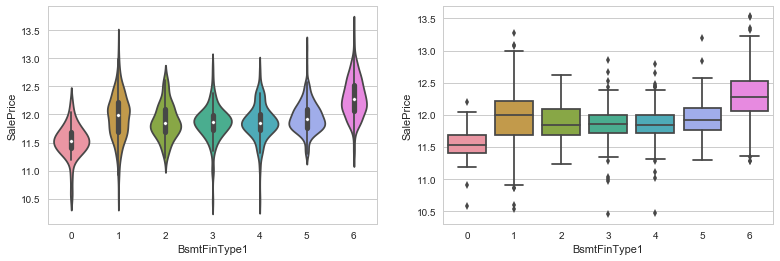

BsmtFinType2
   BsmtFinType2  Counts
0             0      38
1             1    1256
2             2      46
3             3      54
4             4      33
5             5      19
6             6      14


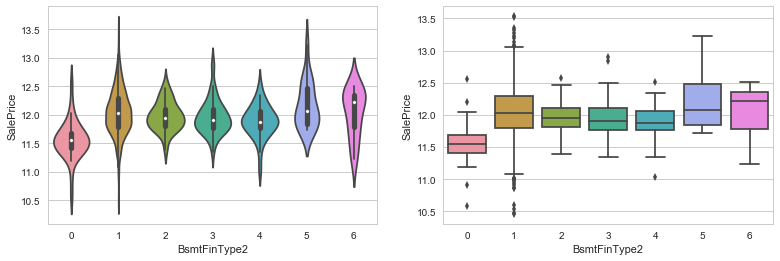

Heating
  Heating  Counts
0   Floor       1
1    GasA    1428
2    GasW      18
3    Grav       7
4    OthW       2
5    Wall       4


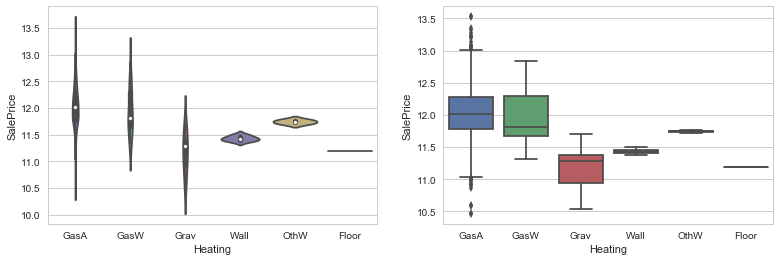

HeatingQC
   HeatingQC  Counts
0          1       1
1          2      49
2          3     428
3          4     241
4          5     741


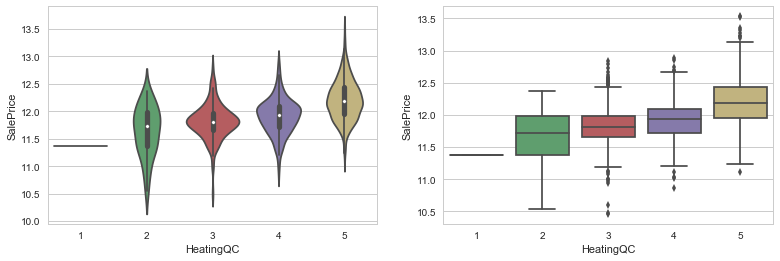

CentralAir
  CentralAir  Counts
0          N      95
1          Y    1365


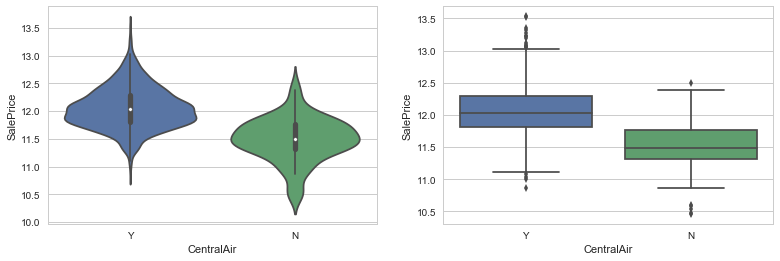

Electrical
  Electrical  Counts
0      FuseA      94
1      FuseF      27
2      FuseP       3
3        Mix       1
4      SBrkr    1335


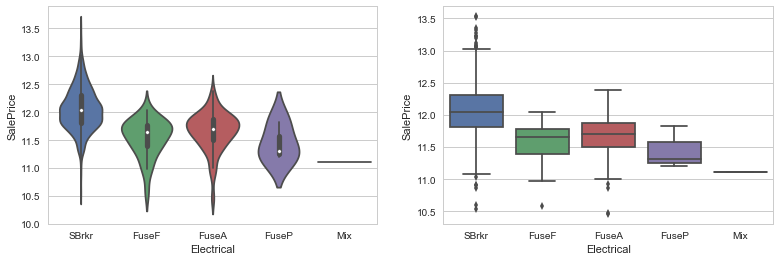

KitchenQual
   KitchenQual  Counts
0            2      39
1            3     735
2            4     586
3            5     100


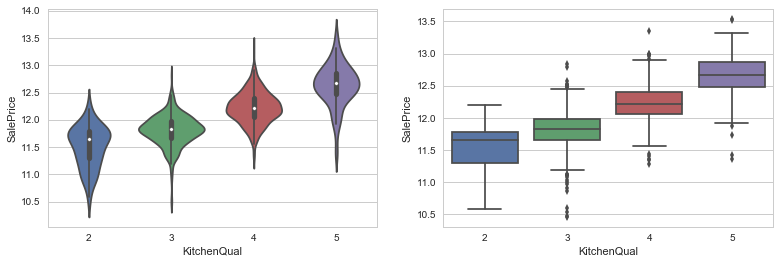

Functional
  Functional  Counts
0       Maj1      14
1       Maj2       5
2       Min1      31
3       Min2      34
4        Mod      15
5        Sev       1
6        Typ    1360


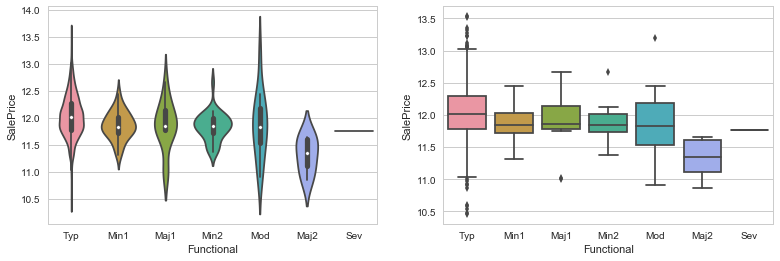

FireplaceQu
   FireplaceQu  Counts
0            0     690
1            1      20
2            2      33
3            3     313
4            4     380
5            5      24


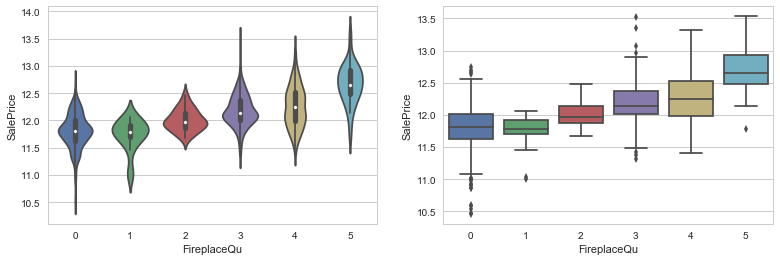

GarageType
  GarageType  Counts
0     2Types       6
1     Attchd     870
2    Basment      19
3    BuiltIn      88
4    CarPort       9
5     Detchd     387
6          N      81


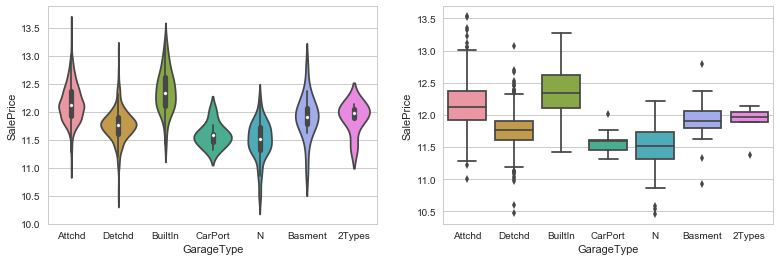

GarageFinish
  GarageFinish  Counts
0          Fin     352
1            N      81
2          RFn     422
3          Unf     605


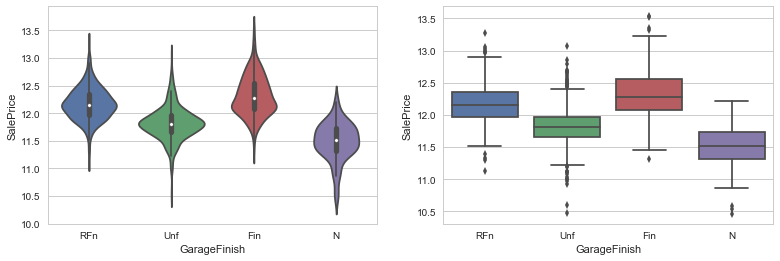

GarageQual
   GarageQual  Counts
0           0      81
1           1       3
2           2      48
3           3    1311
4           4      14
5           5       3


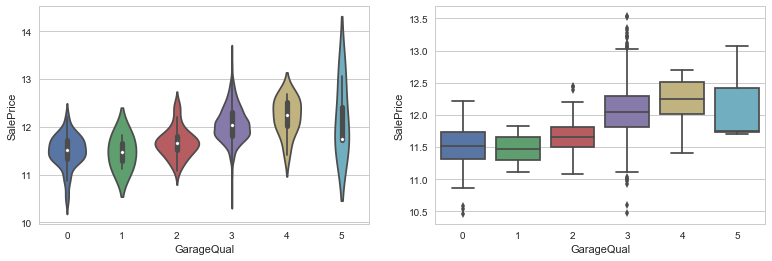

GarageCond
   GarageCond  Counts
0           0      81
1           1       7
2           2      35
3           3    1326
4           4       9
5           5       2


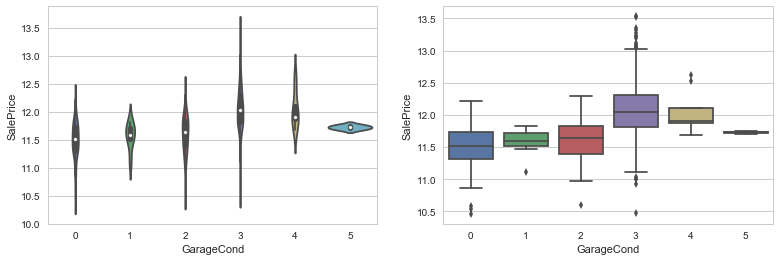

PavedDrive
  PavedDrive  Counts
0          N      90
1          P      30
2          Y    1340


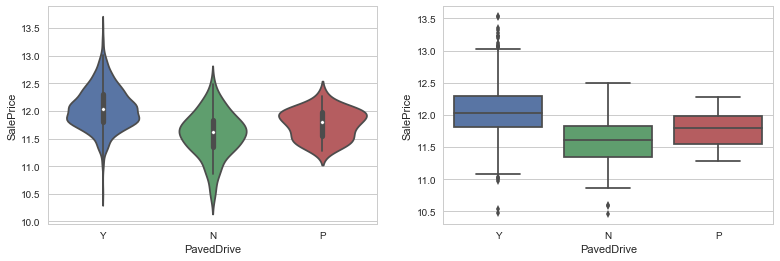

PoolQC
   PoolQC  Counts
0       0    1453
1       2       2
2       4       3
3       5       2


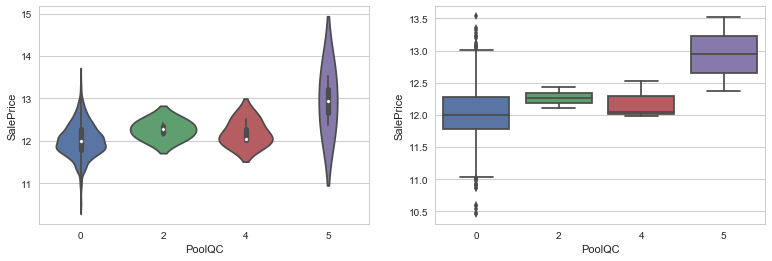

Fence
   Fence  Counts
0  GdPrv      59
1   GdWo      54
2  MnPrv     157
3   MnWw      11
4      N    1179


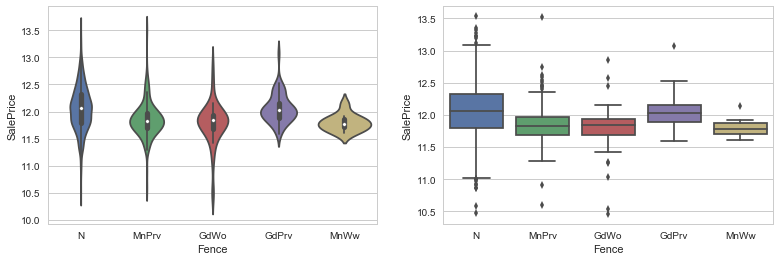

MiscFeature
  MiscFeature  Counts
0        Gar2       2
1           N    1406
2        Othr       2
3        Shed      49
4        TenC       1


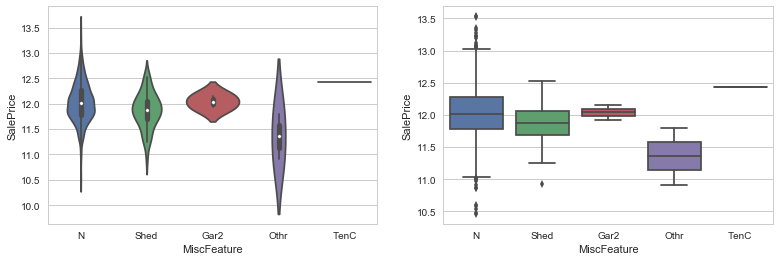

SaleType
  SaleType  Counts
0      COD      43
1      CWD       4
2      Con       2
3    ConLD       9
4    ConLI       5
5    ConLw       5
6      New     122
7      Oth       3
8       WD    1267


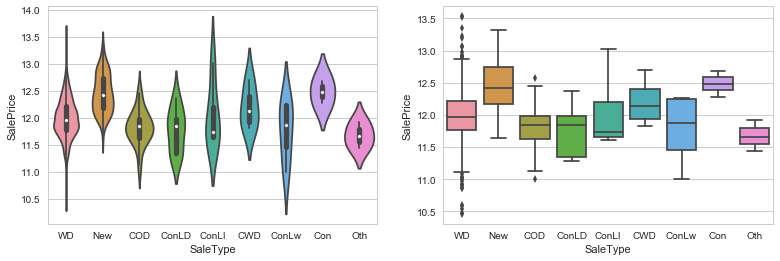

SaleCondition
  SaleCondition  Counts
0       Abnorml     101
1       AdjLand       4
2        Alloca      12
3        Family      20
4        Normal    1198
5       Partial     125


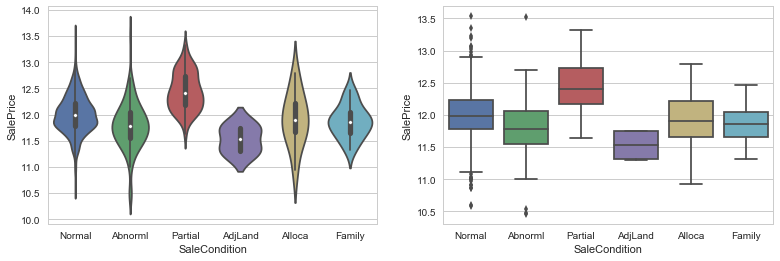

GarageCars
   GarageCars  Counts
0         0.0      81
1         1.0     369
2         2.0     824
3         3.0     181
4         4.0       5


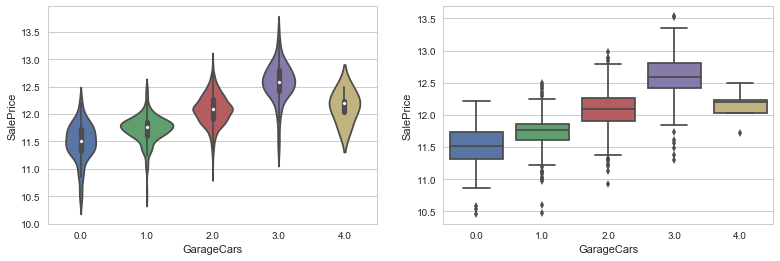

FullBath
   FullBath  Counts
0         0       9
1         1     650
2         2     768
3         3      33


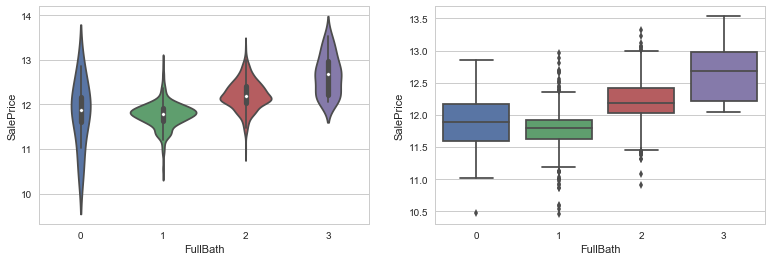

TotRmsAbvGrd
    TotRmsAbvGrd  Counts
0              2       1
1              3      17
2              4      97
3              5     275
4              6     402
5              7     329
6              8     187
7              9      75
8             10      47
9             11      18
10            12      11
11            14       1


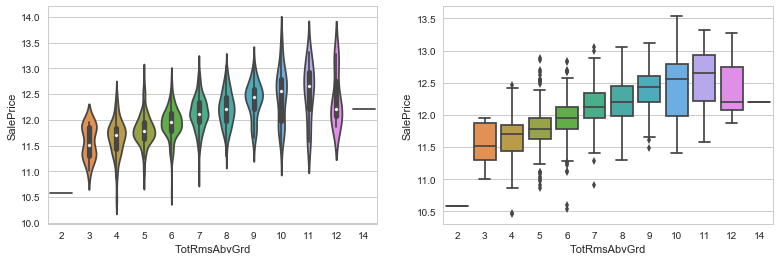

YearBuilt
     YearBuilt  Counts
0         1872       1
1         1875       1
2         1880       4
3         1882       1
4         1885       2
5         1890       2
6         1892       2
7         1893       1
8         1898       1
9         1900      10
10        1904       1
11        1905       1
12        1906       1
13        1908       2
14        1910      17
15        1911       1
16        1912       3
17        1913       1
18        1914       7
19        1915      10
20        1916       8
21        1917       1
22        1918       7
23        1919       3
24        1920      30
25        1921       6
26        1922       8
27        1923       7
28        1924       7
29        1925      16
..         ...     ...
82        1981       5
83        1982       6
84        1983       4
85        1984       9
86        1985       5
87        1986       5
88        1987       3
89        1988      11
90        1989       3
91        1990      12
92        1991       5
9

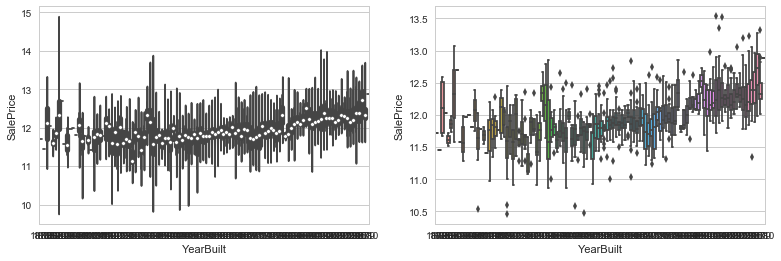

YearRemodAdd
    YearRemodAdd  Counts
0           1950     178
1           1951       4
2           1952       5
3           1953      10
4           1954      14
5           1955       9
6           1956      10
7           1957       9
8           1958      15
9           1959      18
10          1960      12
11          1961       8
12          1962      14
13          1963      13
14          1964      11
15          1965      19
16          1966      15
17          1967      12
18          1968      17
19          1969      14
20          1970      26
21          1971      18
22          1972      20
23          1973      11
24          1974       7
25          1975      10
26          1976      30
27          1977      25
28          1978      16
29          1979      10
..           ...     ...
31          1981       8
32          1982       7
33          1983       5
34          1984       7
35          1985       9
36          1986       5
37          1987      10
38          

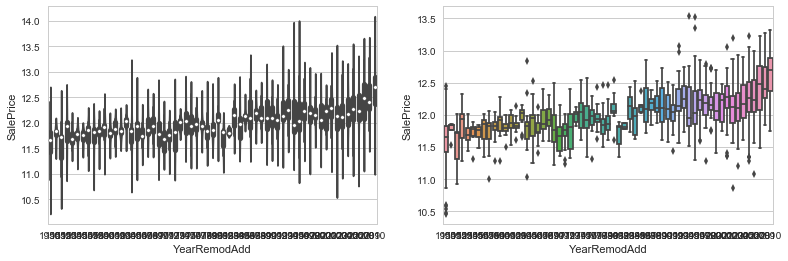

Fireplaces
   Fireplaces  Counts
0           0     690
1           1     650
2           2     115
3           3       5


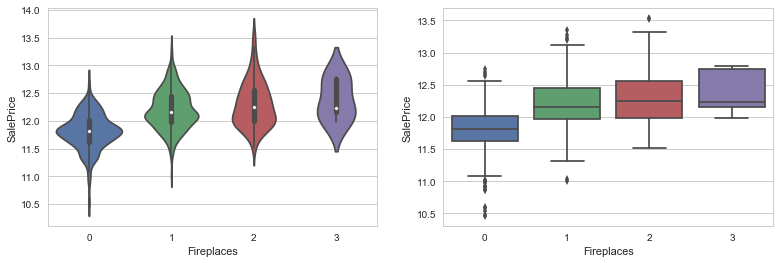

GarageYrBlt
    GarageYrBlt  Counts
0           0.0      81
1        1900.0       1
2        1906.0       1
3        1908.0       1
4        1910.0       3
5        1914.0       2
6        1915.0       2
7        1916.0       5
8        1918.0       2
9        1920.0      14
10       1921.0       3
11       1922.0       5
12       1923.0       3
13       1924.0       3
14       1925.0      10
15       1926.0       6
16       1927.0       1
17       1928.0       4
18       1929.0       2
19       1930.0       8
20       1931.0       4
21       1932.0       3
22       1933.0       1
23       1934.0       2
24       1935.0       4
25       1936.0       5
26       1937.0       2
27       1938.0       3
28       1939.0       9
29       1940.0      14
..          ...     ...
68       1981.0      10
69       1982.0       4
70       1983.0       7
71       1984.0       8
72       1985.0      10
73       1986.0       6
74       1987.0      11
75       1988.0      14
76       1989.0      10
77  

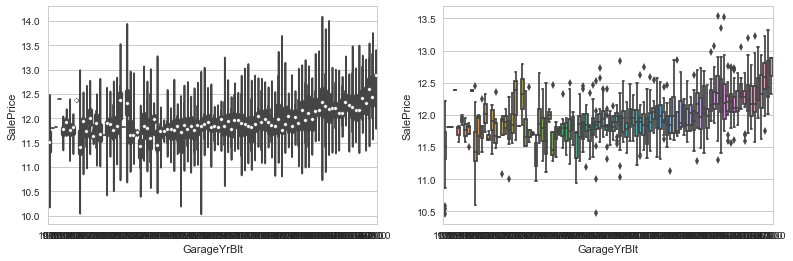

BsmtFullBath
   BsmtFullBath  Counts
0           0.0     856
1           1.0     588
2           2.0      15
3           3.0       1


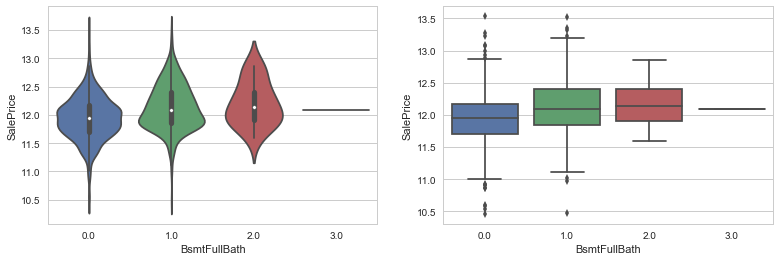

BedroomAbvGr
   BedroomAbvGr  Counts
0             0       6
1             1      50
2             2     358
3             3     804
4             4     213
5             5      21
6             6       7
7             8       1


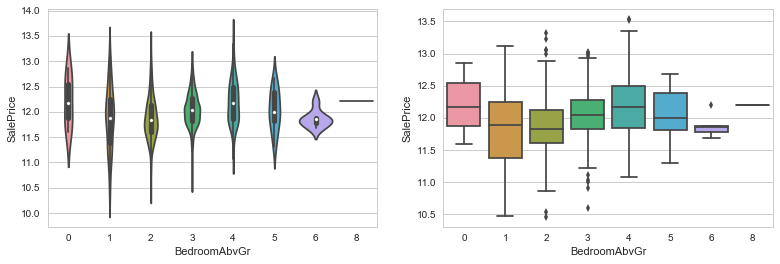

MoSold
    MoSold  Counts
0        1      58
1        2      52
2        3     106
3        4     141
4        5     204
5        6     253
6        7     234
7        8     122
8        9      63
9       10      89
10      11      79
11      12      59


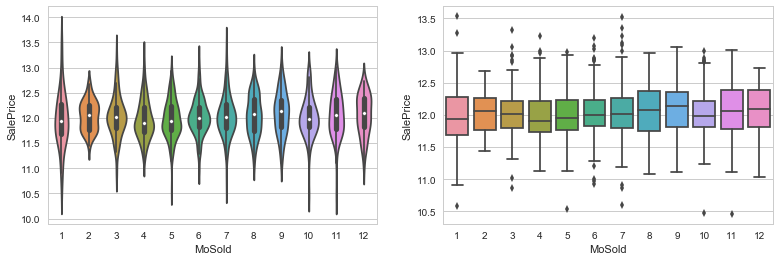

BsmtHalfBath
   BsmtHalfBath  Counts
0           0.0    1378
1           1.0      80
2           2.0       2


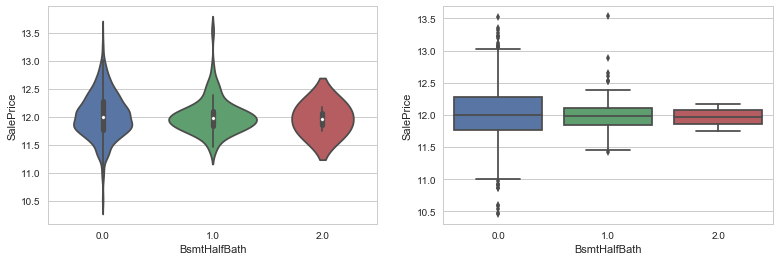

YrSold
   YrSold  Counts
0    2006     314
1    2007     329
2    2008     304
3    2009     338
4    2010     175


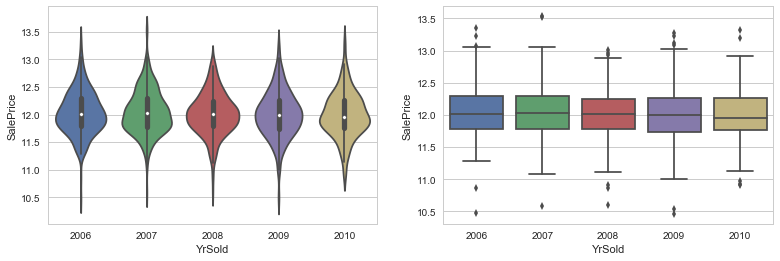

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


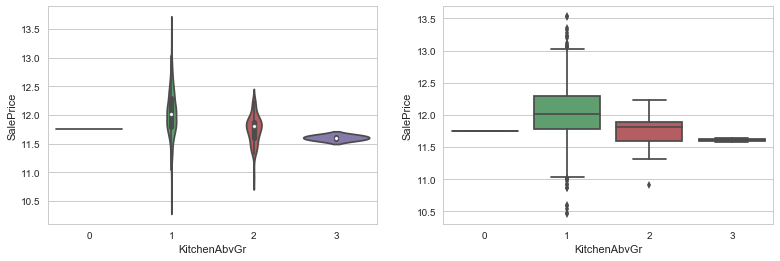

In [25]:
plt.rcParams["figure.figsize"] = (13,4)
for col in cat_ls:
    show_viobox(df, col)

## categorical data 선택

Neighborhood, MasVnrType, SaleType, MSZoning

# 1차 모델분석 numeric data
 - OLS 
 - F_test
 - 상관계수
 - 다중공선성

### OLS 

In [26]:
df_all = df.copy() 
model_num = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(ExterQual) + scale(KitchenQual) + scale(GarageArea) + scale(BsmtQual) + scale(YearBuilt) + scale(YearRemodAdd) + scale(OverallCond)", data = df_all)
result_num = model_num.fit()
print(result_num.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     696.6
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:35:20   Log-Likelihood:                 611.27
No. Observations:                1460   AIC:                            -1199.
Df Residuals:                    1448   BIC:                            -1135.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.0241    

### F_test `anova_lm`

In [27]:
sm.stats.anova_lm(result_num, typ=2).sort_values('PR(>F)')

sum_sq      df           F        PR(>F)
scale(OverallQual)    4.073561     1.0  159.413562  9.563978e-35
scale(OverallCond)    4.037749     1.0  158.012096  1.805537e-34
scale(YearBuilt)      3.659031     1.0  143.191440  1.551681e-31
scale(TotSF)          2.097960     1.0   82.100963  4.079722e-19
scale(GrLivArea)      1.540141     1.0   60.271438  1.552461e-14
scale(GarageCars)     0.959421     1.0   37.545684  1.148790e-09
scale(KitchenQual)    0.400774     1.0   15.683767  7.850095e-05
scale(BsmtQual)       0.284217     1.0   11.122458  8.744584e-04
scale(ExterQual)      0.020620     1.0    0.806952  3.691724e-01
scale(GarageArea)     0.014101     1.0    0.551823  4.576942e-01
scale(YearRemodAdd)   0.007601     1.0    0.297454  5.855670e-01
Residual             37.001347  1448.0         NaN           NaN

ExterQual, GarageArea, YearRemodAdd는 p-value가 높다

### 상관계수

In [28]:
cor_ls = ['OverallQual', 'OverallCond','TotSF', 'GrLivArea', 'GarageCars', 'KitchenQual', 'BsmtQual', 'YearBuilt']

df_cor = df[cor_ls]
df_cor.corr()

OverallQual  OverallCond     TotSF  GrLivArea  GarageCars  \
OverallQual     1.000000    -0.091932  0.668155   0.593007    0.600671   
OverallCond    -0.091932     1.000000 -0.143814  -0.079686   -0.185758   
TotSF           0.668155    -0.143814  1.000000   0.874373    0.536413   
GrLivArea       0.593007    -0.079686  0.874373   1.000000    0.467247   
GarageCars      0.600671    -0.185758  0.536413   0.467247    1.000000   
KitchenQual     0.673331    -0.026707  0.502738   0.420563    0.509810   
BsmtQual        0.629379    -0.164996  0.514299   0.327956    0.449194   
YearBuilt       0.572323    -0.375983  0.347133   0.199010    0.537850   

             KitchenQual  BsmtQual  YearBuilt  
OverallQual     0.673331  0.629379   0.572323  
OverallCond    -0.026707 -0.164996  -0.375983  
TotSF           0.502738  0.514299   0.347133  
GrLivArea       0.420563  0.327956   0.199010  
GarageCars      0.509810  0.449194   0.537850  
KitchenQual     1.000000  0.510938   0.530165  
BsmtQual        0.510938  1.000000   0.602797  
YearBuilt       0.530165  0.602797   1.000000

TotSF과 GrLivArea의  상관계수가 높다.

### 다중공선성 확인

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_cor.values, i) for i in range(df_cor.shape[1])]
vif["features"] = df_cor.columns
vif

VIF Factor     features
0   62.750509  OverallQual
1   26.643820  OverallCond
2   63.281737        TotSF
3   44.915478    GrLivArea
4   11.464623   GarageCars
5   57.167953  KitchenQual
6   33.751470     BsmtQual
7   65.338444    YearBuilt

# 2차 모델분석 ( Category data 포함 )
 - Neighborhood, MasVnrType, SaleType, MSZoning 추가
 - F_test

###  F_test `anova_lm'

In [30]:
df_all = df.copy()
model_all = sm.OLS.from_formula("SalePrice ~ C(Neighborhood) + C(MasVnrType) + C(SaleType) + C(MSZoning) + scale(OverallQual) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearBuilt) + scale(OverallCond)", data = df_all)
result_all = model_all.fit()

In [31]:
sm.stats.anova_lm(result_all, typ=2).sort_values('PR(>F)')

sum_sq      df           F         PR(>F)
scale(GrLivArea)    12.515051     1.0  601.144353  6.859299e-111
scale(OverallCond)   3.193523     1.0  153.396776   1.610690e-33
scale(OverallQual)   3.018038     1.0  144.967589   7.471820e-32
C(Neighborhood)      4.262204    24.0    8.530395   2.742246e-28
scale(GarageCars)    2.645645     1.0  127.080136   2.767290e-28
scale(BsmtQual)      1.321724     1.0   63.487326   3.298626e-15
C(MSZoning)          1.469266     4.0   17.643570   3.844522e-14
scale(YearBuilt)     0.871362     1.0   41.854775   1.352003e-10
scale(KitchenQual)   0.421232     1.0   20.233328   7.416735e-06
C(SaleType)          0.323432     8.0    1.941952   5.039756e-02
C(MasVnrType)        0.070271     4.0    0.843840   4.973378e-01
Residual            29.396021  1412.0         NaN            NaN

In [32]:
df_all = df.copy()
model_all = sm.OLS.from_formula("SalePrice ~ C(Neighborhood) + C(MSZoning) + scale(OverallQual) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearBuilt) + scale(OverallCond)", data = df_all)

result_all = model_all.fit()
print(result_all.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     277.1
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:35:20   Log-Likelihood:                 769.14
No. Observations:                1460   AIC:                            -1466.
Df Residuals:                    1424   BIC:                            -1276.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# 다항회귀와 교차검증
- `cross_val_score` 사용

$$ y = OQ + OC + GA + KQ + GC + BQ + YB + Category $$

In [33]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(10)
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))

0.8611639414474418


$\Diamond$ $$ y = OQ + OC + GA + GA^2 + KQ + GC + BQ + YB + Category $$

In [34]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8740162661327588


$\Diamond$ $$ y = OQ + OC + GA + GA^2 + GA^3 + KQ + GC + BQ + YB + Category $$

In [35]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8768850176780472


$\Diamond$ $$ y = OQ + OC + GA + KQ + KQ^2 + KQ^3 + GC + BQ + YB + Category $$

In [36]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3)) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.86138566816928


$\Diamond$  $$ y = OQ + OC + GA + KQ + GC + BQ + BQ^2 + BQ^3 + YB + Category $$

In [37]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(I(BsmtQual**2)) + scale(I(BsmtQual**3)) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8614886615374939


$\Diamond$ $$ y = OQ + OC + GA + KQ + GC + BQ + BQ^2 + BQ^3 + BQ^4 + YB + Category $$

In [38]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(I(BsmtQual**2)) + scale(I(BsmtQual**3)) + scale(I(BsmtQual**4)) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8613280215623472


$\Diamond$ $$ y = OQ + OC + GA + GA^2 + GA^3 + KQ +KQ^2 +KQ^3 + GC + BQ + YB + Category $$

In [39]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3))  + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418
# GAorigin : 0.8768850176780474
# KQorigin : 0.86138566816928


0.8785461600496355


#### 교차검증 결과 상위 스코어

A 모델 : $ y = OQ + OC + GA + GA^2 + GA^3 + KQ +KQ^2 +KQ^3 + GC + BQ + YB + Category $

B 모델 : $ y = OQ + OC + GA + GA^2 + GA^3 + KQ  + GC + BQ + YB + Category $

#### A 모델 결과 분석

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ +KQ^2 +KQ^3 + GC + BQ + YB + Category $$

In [40]:
model_a = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3)) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df)
result_a = model_a.fit()
print(result_a.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     284.0
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:35:22   Log-Likelihood:                 856.26
No. Observations:                1460   AIC:                            -1633.
Df Residuals:                    1420   BIC:                            -1421.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### B 모델 결과 분석

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ  + GC + BQ + YB + Category $$

In [41]:
model_b = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df)
result_b = model_b.fit()

print(result_b.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     294.9
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:35:23   Log-Likelihood:                 845.50
No. Observations:                1460   AIC:                            -1615.
Df Residuals:                    1422   BIC:                            -1414.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# 레버리지, 아웃라이어

### 레버리지 시각화

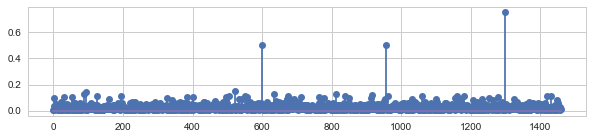

In [42]:
influence = result_a.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

### 표준화 잔차 시각화

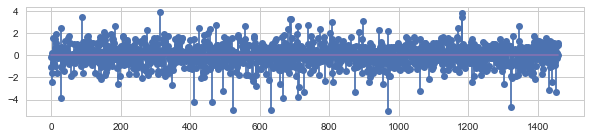

In [43]:
plt.figure(figsize=(10, 2))
plt.stem(result_a.resid_pearson)
plt.show()

### Cook's Distance

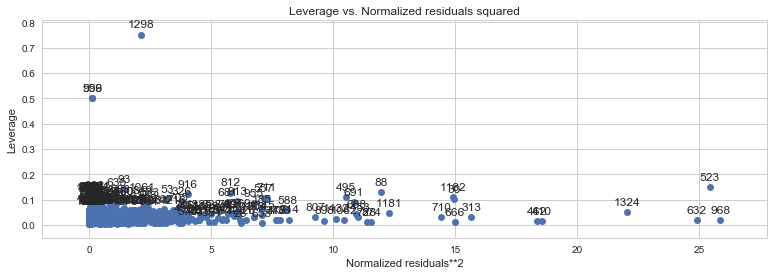

In [44]:
plt.figure(figsize=(50, 50))
sm.graphics.plot_leverage_resid2(result_a)
plt.show()

### 아웃라이어 제거 A모델

In [45]:
influence = result_a.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (1460 - 1 - 38)
idx = np.where(cooks_d2 > fox_cr)[0]
idx = list(set(idx) - set([599, 956]))
df_fin1 = df.copy()
df_fin1 = df_fin1.drop(df_fin1.index[idx])

In [46]:
model_a2 = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3)) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df_fin1)
result_a2 = model_a2.fit()
print(result_a2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     402.0
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:35:30   Log-Likelihood:                 1171.7
No. Observations:                1366   AIC:                            -2263.
Df Residuals:                    1326   BIC:                            -2055.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

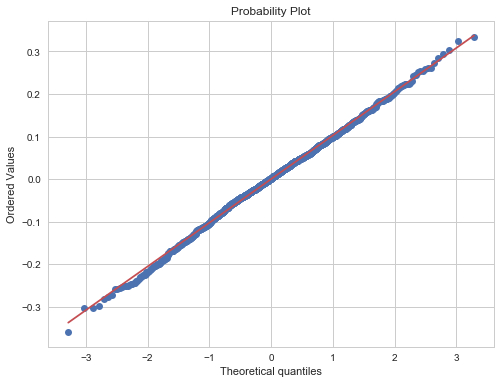

Chi^2       :  3.226
P-value     :  0.199


In [47]:
plt.figure(figsize=(8, 6))
sp.stats.probplot(result_a2.resid, plot=plt)
plt.show()
#잔차 정규성 P-value
test = sms.omni_normtest(result_a2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

### 아웃라이어 제거 B모델

In [48]:
influence = result_b.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 3 / (1460 - 1 - 37)
idx = np.where(cooks_d2 > fox_cr)[0]
idx = list(set(idx) - set([599, 956]))
df_fin2 = df.copy()
df_fin2 = df_fin2.drop(df_fin2.index[idx])

In [49]:
model_b2 = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df_fin2)
result_b2 = model_b2.fit()

print(result_b2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     421.5
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:35:31   Log-Likelihood:                 1178.9
No. Observations:                1336   AIC:                            -2282.
Df Residuals:                    1298   BIC:                            -2084.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

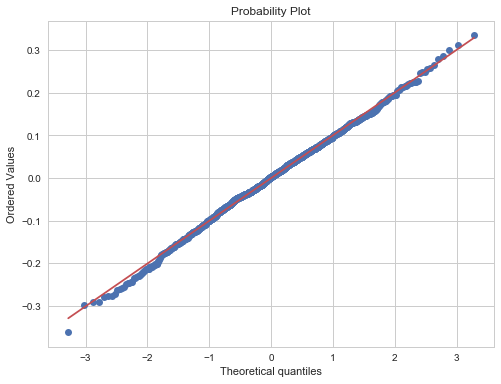

Chi^2       :  4.461
P-value     :  0.107


In [50]:
plt.figure(figsize=(8, 6))
sp.stats.probplot(result_b2.resid, plot=plt)
plt.show()
#잔차 정규성 P-value
test = sms.omni_normtest(result_b2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

## 정규화 선형회귀 비교
 - `klearn.linear_model` 사용
 - Ridge 
 - Lasso 
 - Elastic

In [52]:
from patsy import dmatrices
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

y, X = dmatrices("np.exp(SalePrice) ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3)) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df_fin1 , return_type = 'dataframe' )

#poly = PolynomialFeatures(1)
model1_LR = LinearRegression().fit(X, y)
model1_ridge = Ridge().fit(X, y)
model1_lasso = Lasso().fit(X, y)
model1_EN = ElasticNet().fit(X, y)
                
cv = KFold(20, shuffle=False)
print('[LR]')
sco = list(cross_val_score(model1_LR, X, y, scoring="r2", cv=cv))
score = [ i for i in sco if i > 0]
print('score : ', score,'\n',
      'mean : ', np.mean(score),'\n',
      'std : ', np.std(score), '\n')
print('[Ridge]')
print('score : ', cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv)),'\n',
      'std : ', np.std(cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv)),'\n')

print('\n[Lasso]')
print('score : ', cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv)),'\n',
      'std : ', np.std(cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv)),'\n')

print('\n[Elastic-net]')
print('score : ', cross_val_score(model1_EN, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_EN, X, y, scoring="r2", cv=cv)),'\n',
      'std : ', np.std(cross_val_score(model1_EN, X, y, scoring="r2", cv=cv)),'\n')

[LR]
score :  [0.9005140045933867, 0.8811637879922979, 0.8563358964220256, 0.9300921035293935, 0.9098295387871654, 0.8958982014745231, 0.9016694126433731, 0.8442393010197575, 0.9229543063746263, 0.8881170314743577, 0.8680954785736598, 0.873501883347165, 0.8532304047557641, 0.8646760663125158, 0.8944317554409611, 0.8988931754185173, 0.8714484296644684, 0.9024317049398518, 0.8877105493360621] 
 mean :  0.8865912122157829 
 std :  0.022715890653353235 

[Ridge]
score :  [0.90190015 0.87770224 0.85098501 0.92731622 0.90643185 0.8933326
 0.89939408 0.84772331 0.9215342  0.89157407 0.86706914 0.88115312
 0.86061374 0.86079792 0.8891195  0.89412947 0.86633112 0.88203306
 0.89782228 0.88196748] 
 mean :  0.8849465289662104 
 std :  0.021139962550820495 


[Lasso]
score :  [0.89940488 0.87715023 0.85381663 0.92844399 0.90662252 0.89335964
 0.89971937 0.84525685 0.92275183 0.88994216 0.86717609 0.87698916
 0.86180271 0.86410367 0.88997089 0.8917305  0.8674327  0.88408061
 0.89837375 0.88588239] 

## Kaggle Score

### A 모델
- Kaggle Score 
    - RMSE = 0.14909

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ +KQ^2 +KQ^3 + GC + BQ + YB + Category $$

### B 모델
- Kaggle Score 
    - RMSE = 0.14826

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ  + GC + BQ + YB + Category $$